# DCA Polymarket Backtesting Engine

A backtesting framework for **Dollar-Cost Averaging (DCA)** strategies on [Polymarket](https://polymarket.com/) prediction markets, using real orderbook data collected via WebSocket.

### What This Notebook Does

This notebook simulates a multi-tier DCA trading strategy against **reconstructed orderbook snapshots** — not just mid-prices — so that execution is realistic (spreads, partial fills, liquidity depth are all accounted for).

### Strategy Highlights
- **Multi-tier DCA entries** — gradual position building as price crosses configurable thresholds
- **Dynamic hedging** — buys the opposite outcome when the main position drops, with tick-level confirmation
- **Panic flip detection** — detects rapid resolution and flips to the winning side
- **Late-game stop-loss disable** — avoids getting stopped out during pre-resolution volatility
- **Noise filtering** — ignores wide-spread ticks to prevent false signals
- **Optuna hyperparameter optimization** — finds optimal parameters across multiple days of data
- **ML market-adaptive optimization** — learns which parameters work best under which market conditions

### Data Pipeline Overview

The data feeding this notebook comes from a custom **real-time Polymarket orderbook collector** (see `collector_parquet/`). The pipeline is:

1. **Collect** — `websocket_client.py` subscribes to Polymarket's WebSocket API for `book` and `price_change` events
2. **Store** — `database.py` buffers messages and writes them as Parquet chunk files
3. **Merge** — `merger.py` concatenates all chunk files into a single `snapshots.parquet`
4. **Reconstruct** — `reconstruct_orderbooks.py` replays book snapshots + price_change deltas to rebuild the full orderbook at every tick
5. **Backtest** — this notebook loads the reconstructed parquet and simulates the strategy

### Expected Data Columns
`datetime`, `asset_id`, `market_id`, `ob_best_bid`, `ob_best_ask`, `ob_mid_price`, `orderbook_bids`, `orderbook_asks`

---

## Table of Contents
1. [Setup & Imports](#1-setup--imports)
2. [Data Loading](#2-data-loading)
3. [Core Functions](#3-core-functions) — orderbook parsing & trade execution
4. [Backtest Engine](#4-backtest-engine) — the DCA strategy simulation (v19)
5. [Visualization](#5-visualization) — price charts with trade markers
6. [Optuna Optimizer](#6-optuna-optimizer) — multi-dataset parameter search
7. [Market Analysis](#7-market-analysis) — threshold & win-rate analysis
8. [Known Winners & Market Data](#8-known-winners--market-data)
9. [Run Backtest](#9-run-backtest)
10. [Run Optimization](#10-run-optimization)
11. [Run ML Optimization](#11-run-ml-market-adaptive-optimization)

---
## 1. Setup & Imports

Standard scientific Python stack + Optuna for hyperparameter optimization.

In [30]:
import pandas as pd
import numpy as np
import json
import warnings
from typing import Dict, List, Optional, Tuple
from collections import defaultdict

warnings.filterwarnings('ignore')
print("✅ Core imports ready")

✅ Core imports ready


In [31]:
# Visualization imports
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.style.use('seaborn-v0_8-whitegrid')
print("✅ Visualization imports ready")

✅ Visualization imports ready


In [32]:
# Install optuna if not already available
# pip install optuna

In [33]:
# Optional: Optuna for optimization
try:
    import optuna
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    OPTUNA_AVAILABLE = True
    print("✅ Optuna ready")
except ImportError:
    OPTUNA_AVAILABLE = False
    print("⚠️ Optuna not installed - optimization disabled")
    print("   Install with: pip install optuna")

✅ Optuna ready


---
## 2. Data Loading

Each parquet file contains **reconstructed orderbook data** for markets.

Both `collector_parquet/` and `live/` (parquet mode) produce files with orderbooks reconstructed **on-the-fly** during collection—no separate reconstruction step needed.

The `load_data()` function below automatically normalizes column names to support both:
- **New format**: `best_bid`, `best_ask`, `mid_price` (with `event_type`, `raw_json`)
- **Legacy format**: `ob_best_bid`, `ob_best_ask`, `ob_mid_price`

Update the paths below to point to your parquet files.

In [34]:
# ── Configure data paths ──────────────────────────────────────────────────────
# Each file is a parquet with full orderbook data (reconstructed on-the-fly).
# Works with both new (best_bid/best_ask) and legacy (ob_best_bid/ob_best_ask) formats.

DATA_PATHS = {
    '24jan': 'snapshots_24jan_reconstructed.parquet',
    '25jan': 'snapshots_25jan_reconstructed.parquet',
    '26jan': 'snapshots_26jan_reconstructed.parquet',
    '27jan': 'snapshots_27jan_reconstructed.parquet',
    '01feb': 'snapshots_1feb_reconstructed.parquet',
    '02feb': 'snapshots_2feb_reconstructed.parquet',
    '13feb': 'snapshots.parquet'
}

In [35]:
def load_data(path: str) -> pd.DataFrame:
    """Load and validate parquet data.

    Supports both the new collector format (best_bid/best_ask + orderbook_bids/orderbook_asks)
    and the legacy reconstructed format (ob_best_bid/ob_best_ask).
    Columns are normalised to ob_best_bid / ob_best_ask for backward compatibility.
    """
    df = pd.read_parquet(path)
    df['datetime'] = pd.to_datetime(df['datetime'])

    # ── Normalise column names ──
    # New format: best_bid / best_ask  →  rename to ob_best_bid / ob_best_ask
    if 'best_bid' in df.columns and 'ob_best_bid' not in df.columns:
        df = df.rename(columns={'best_bid': 'ob_best_bid', 'best_ask': 'ob_best_ask'})
    if 'mid_price' in df.columns and 'ob_mid_price' not in df.columns:
        df['ob_mid_price'] = df['mid_price']

    # Ensure ob_mid_price exists
    if 'ob_mid_price' not in df.columns:
        df['ob_mid_price'] = (df['ob_best_bid'] + df['ob_best_ask']) / 2

    required_cols = ['datetime', 'asset_id', 'market_id', 'ob_best_bid', 'ob_best_ask']
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    fmt = "new" if 'event_type' in df.columns else "legacy"
    print(f"✅ Loaded {len(df):,} rows, {df['market_id'].nunique()} markets  [{fmt} format]")
    print(f"   Time range: {df['datetime'].min()} to {df['datetime'].max()}")
    return df


def list_markets(df: pd.DataFrame):
    """Display available markets in the dataframe."""
    markets = df['market_id'].unique()
    print(f"\n📋 {len(markets)} Markets:")
    for i, m in enumerate(markets):
        n = len(df[df['market_id'] == m])
        print(f"  {i}: {m[:50]}... ({n:,} rows)")

---
## 3. Core Functions

**Orderbook parsing and trade execution.**

Unlike simple backtests that assume you trade at the mid-price, these functions walk the actual orderbook levels — consuming liquidity at each price tier — giving realistic execution with spread costs and partial fills.

In [36]:
def parse_orderbook_levels(json_str: str) -> List[Dict]:
    """Parse orderbook levels from JSON string."""
    if not json_str or pd.isna(json_str):
        return []
    try:
        return json.loads(json_str)
    except:
        return []

In [37]:
def execute_buy(asks_json: str, amount_usd: float) -> Tuple[float, float, float]:
    """
    Execute buy order against asks.

    Args:
        asks_json: JSON string of ask levels
        amount_usd: Amount to spend in USD

    Returns:
        (shares_bought, total_cost, avg_price)
    """
    asks = parse_orderbook_levels(asks_json)
    if not asks or amount_usd <= 0:
        return 0, 0, 0

    shares, cost, remaining = 0, 0, amount_usd
    for level in asks:
        if remaining <= 0:
            break
        p, s = level['price'], level['size']
        take = min(s, remaining / p)
        shares += take
        cost += take * p
        remaining -= take * p

    return shares, cost, cost / shares if shares > 0 else 0

In [38]:
def execute_sell(bids_json: str, shares_to_sell: float) -> Tuple[float, float, float]:
    """
    Execute sell order against bids.

    Args:
        bids_json: JSON string of bid levels
        shares_to_sell: Number of shares to sell

    Returns:
        (shares_sold, total_proceeds, avg_price)
    """
    bids = parse_orderbook_levels(bids_json)
    if not bids or shares_to_sell <= 0:
        return 0, 0, 0

    sold, proceeds, remaining = 0, 0, shares_to_sell
    for level in bids:
        if remaining <= 0:
            break
        p, s = level['price'], level['size']
        take = min(s, remaining)
        sold += take
        proceeds += take * p
        remaining -= take

    return sold, proceeds, proceeds / sold if sold > 0 else 0


print("✅ Core functions ready")

✅ Core functions ready


---
## 4. Backtest Engine

The main DCA strategy simulation (v19). Key features:

| Feature | Description |
|---------|-------------|
| **Multi-tier DCA** | Gradual entries at 4 price thresholds with configurable capital weights |
| **Dynamic hedging** | Buys opposite outcome on confirmed drops; sells hedge if it also drops |
| **Panic flip** | Detects rapid price surges (resolution) and flips to the winning side |
| **Early entry** | Enters stable-trending markets before the standard trading window |
| **Hedge promotion** | Promotes a winning hedge to main position and closes the original |
| **Late-game SL disable** | Stops are turned off in the final 10% of market life |
| **Noise filtering** | Wide-spread ticks are ignored for exit decisions |
| **Grace period** | 180s cooldown after entry before stop-losses activate |

### Default Parameters
These were found via Optuna optimization across 6 days of historical data.

In [39]:
# Default strategy parameters

DEFAULT_PARAMS = {
    'cooldown_periods': 6,
    'dca_tier_1': 0.9639,
    'dca_tier_2': 0.9744,
    'dca_tier_3': 0.9958,
    'entry_threshold': 0.9603,
    'exit_stop_loss': 0.7889,
    'stop_loss_pct': 0.1400,
    'take_profit_pct': 0.0350,
    'weight_entry': 0.4899,
    'weight_tier_1': 0.2783,
    'weight_tier_2': 0.1002,
    'weight_tier_3': 0.0572,
}


def normalize_params(params: Dict) -> Dict:
    """Normalize parameters with defaults and weight normalization."""
    p = DEFAULT_PARAMS.copy()
    p.update(params or {})

    # Normalize weights to sum to 1
    w_keys = ['weight_entry', 'weight_tier_1', 'weight_tier_2', 'weight_tier_3']
    total = sum(p[k] for k in w_keys)
    for k in w_keys:
        p[k] /= total
    return p

In [40]:
"""
DCA Backtest Engine v19 - SIMPLIFIED HEDGE + DROP CONFIRMATION

Changes from v18:
1. Single hedge only - if hedge drops, SELL it (don't double hedge)
2. After selling hedge, can re-hedge later if conditions trigger again
3. Drop confirmation - need X consecutive ticks below threshold before acting
   (prevents reacting to sharp temporary spikes)

Features:
- Late-game stop loss disable
- HEDGE on fast/slow drop (with confirmation)
- Hedge SELL if it drops (with confirmation)
- Can re-hedge after selling previous hedge
- PANIC FLIP for rapid resolution detection
- Stability-based early entry
"""

def calculate_stability_metrics(price_history: List[Tuple], window_seconds: int = 1800) -> Dict:
    """Calculate stability metrics from price history."""
    if len(price_history) < 10:
        return {'volatility': float('inf'), 'avg_price': 0, 'range': float('inf'), 'valid': False}
    
    prices = [p for _, p in price_history]
    return {
        'volatility': np.std(prices),
        'avg_price': np.mean(prices),
        'min_price': min(prices),
        'max_price': max(prices),
        'range': max(prices) - min(prices),
        'valid': True
    }


def check_early_entry_eligible(
    price_history: List[Tuple],
    current_price: float,
    market_progress: float,
    ts: pd.Timestamp,
    early_entry_min_progress: float = 0.40,
    early_entry_max_progress: float = 0.90,
    early_entry_price_threshold: float = 0.70,
    early_entry_max_volatility: float = 0.03,
    early_entry_max_range: float = 0.08,
    early_entry_min_duration_minutes: float = 20,
    early_entry_no_drop_threshold: float = 0.06,
    early_entry_no_drop_window: int = 900,
) -> Tuple[bool, str]:
    """Check if early entry conditions are met for a stable trending market."""
    if market_progress < early_entry_min_progress or market_progress >= early_entry_max_progress:
        return False, "outside_early_window"
    
    if current_price < early_entry_price_threshold:
        return False, f"price_{current_price:.2f}_below_{early_entry_price_threshold}"
    
    if len(price_history) < 20:
        return False, "insufficient_history"
    
    progress_in_window = (market_progress - early_entry_min_progress) / (early_entry_max_progress - early_entry_min_progress)
    relaxation_factor = progress_in_window
    
    adj_max_volatility = early_entry_max_volatility * (1 + relaxation_factor * 1.5)
    adj_max_range = early_entry_max_range * (1 + relaxation_factor * 1.5)
    adj_min_duration = early_entry_min_duration_minutes * (1 - relaxation_factor * 0.6)
    
    metrics = calculate_stability_metrics(price_history)
    if not metrics['valid']:
        return False, "invalid_metrics"
    
    if metrics['volatility'] > adj_max_volatility:
        return False, f"volatility_{metrics['volatility']:.3f}_above_{adj_max_volatility:.3f}"
    
    if metrics['range'] > adj_max_range:
        return False, f"range_{metrics['range']:.3f}_above_{adj_max_range:.3f}"
    
    first_ts = price_history[0][0]
    duration_minutes = (ts - first_ts).total_seconds() / 60
    if duration_minutes < adj_min_duration:
        return False, f"duration_{duration_minutes:.1f}min_below_{adj_min_duration:.1f}min"
    
    recent_cutoff = ts - pd.Timedelta(seconds=early_entry_no_drop_window)
    recent_prices = [(t, p) for t, p in price_history if t >= recent_cutoff]
    if len(recent_prices) >= 2:
        recent_max = max(p for _, p in recent_prices)
        recent_drop = recent_max - current_price
        adj_drop_threshold = early_entry_no_drop_threshold * (1 + relaxation_factor * 0.5)
        if recent_drop > adj_drop_threshold:
            return False, f"recent_drop_{recent_drop:.3f}_above_{adj_drop_threshold:.3f}"
    
    return True, f"stable_early_entry_progress_{market_progress:.1%}_vol_{metrics['volatility']:.3f}"


def run_backtest(
    df: pd.DataFrame,
    params: Dict = None,
    known_winners: Dict = None,
    initial_capital: float = 500,
    global_tp_pct: float = 0.20,
    selected_markets: List = None,
    resample: str = '1s',
    verbose: bool = True,
    # Late-game parameters
    late_game_threshold: float = 0.90,
    # Trading window restriction
    last_minutes_only: int = 10,
    # === EARLY ENTRY PARAMETERS ===
    early_entry_enabled: bool = True,
    early_entry_min_progress: float = 0.40,
    early_entry_max_progress: float = 0.90,
    early_entry_price_threshold: float = 0.70,
    early_entry_max_volatility: float = 0.025,
    early_entry_max_range: float = 0.07,
    early_entry_min_duration_minutes: float = 25,
    early_entry_no_drop_threshold: float = 0.05,
    early_entry_no_drop_window: int = 900,
    # === HEDGE PARAMETERS ===
    hedge_enabled: bool = True,
    hedge_drop_points: float = 0.12,        # Fast drop threshold
    hedge_drop_window: int = 90,            # Fast drop time window (seconds)
    hedge_drop_from_entry: float = 0.10,    # Slow drop from entry
    hedge_amount: float = 30.0,
    hedge_late_game_only: bool = True,
    hedge_cooldown_seconds: int = 30,       # Cooldown after selling hedge before re-hedging
    # === DROP CONFIRMATION (prevents reacting to sharp spikes) ===
    hedge_drop_confirmation_ticks: int = 20,  # Need X ticks of drop before hedging
    hedge_exit_confirmation_ticks: int = 15,  # Need X ticks of hedge drop before selling it
    hedge_exit_drop_points: float = 0.08,     # Drop threshold to sell hedge
    # === PANIC FLIP / SAFETY SYSTEM ===
    panic_flip_enabled: bool = True,
    panic_flip_threshold: float = 0.25,
    panic_flip_window: int = 10,
    panic_flip_min_price: float = 0.85,
    panic_flip_late_game_only: bool = True,
    # Grace period
    entry_grace_period: int = 180,
    # Hedge PROMOTION parameters (when hedge wins big)
    hedge_promotion_pnl_pct: float = 0.20,
    hedge_promotion_price: float = 0.50,
    hedge_promotion_delta: float = 0.15,
    # Instant exit
    instant_exit_price: float = 0.99,
    # Noise filtering
    max_spread_for_sl: float = 0.10,
    sl_confirmation_ticks: int = 10,
    # === DEBUG OPTIONS ===
    debug_market: str = None,
) -> Dict:
    """
    Run DCA backtest v19 - Simplified hedge with drop confirmation.
    
    HEDGE LOGIC:
    1. If main position drops (confirmed over X ticks) → hedge to opposite
    2. If hedge position drops (confirmed over X ticks) → SELL the hedge
    3. After selling hedge, can hedge again if conditions re-trigger
    
    DROP CONFIRMATION:
    - Sharp drops for just a few ticks are ignored
    - Only act if drop persists for hedge_drop_confirmation_ticks consecutive ticks
    """
    params = normalize_params(params)

    # Prepare data
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime')
    df = df[df['ob_best_bid'].notna() & df['ob_best_ask'].notna()].copy()

    # Market selection
    if selected_markets is not None:
        all_markets = df['market_id'].unique()
        sel = [all_markets[m] if isinstance(m, int) and m < len(all_markets) else m
               for m in selected_markets]
        df = df[df['market_id'].isin(sel)]

    if verbose:
        print(f"📊 {df['market_id'].nunique()} markets, {len(df):,} rows")

    # Resample if requested
    if resample:
        df['bucket'] = df['datetime'].dt.floor(resample)
        df = df.groupby(['market_id', 'asset_id', 'bucket']).last().reset_index()
        df = df.drop(columns=['datetime']).rename(columns={'bucket': 'datetime'})
        df = df.sort_values('datetime')
        if verbose:
            print(f"⏱️  Resampled to {resample}: {len(df):,} rows")

    # Calculate market time bounds
    market_times = {}
    for mid in df['market_id'].unique():
        mdf = df[df['market_id'] == mid]
        market_times[mid] = {
            'start': mdf['datetime'].min(),
            'end': mdf['datetime'].max(),
            'duration': (mdf['datetime'].max() - mdf['datetime'].min()).total_seconds()
        }

    # =================================================================
    # PERFORMANCE: Pre-compute lookups
    # =================================================================
    market_assets = {mid: df[df['market_id'] == mid]['asset_id'].unique().tolist() 
                     for mid in df['market_id'].unique()}
    
    df = df.reset_index(drop=True)
    market_asset_rows = {}
    for idx, row in df.iterrows():
        key = (row['market_id'], row['asset_id'])
        if key not in market_asset_rows:
            market_asset_rows[key] = []
        market_asset_rows[key].append((row['datetime'], idx))
    
    df_values = df.to_dict('index')
    
    # Debug market setup
    debug_mid = None
    if debug_market:
        for mid in df['market_id'].unique():
            if debug_market in mid:
                debug_mid = mid
                print(f"🔍 DEBUG MODE: Tracking market {debug_mid[:50]}...")
                break
        if debug_mid is None:
            print(f"⚠️ Debug market '{debug_market}' not found")

    def get_latest_row(market_id, asset_id, before_ts):
        """Get the most recent row for market/asset before or at timestamp."""
        key = (market_id, asset_id)
        if key not in market_asset_rows:
            return None
        rows = market_asset_rows[key]
        latest_idx = None
        for row_ts, idx in rows:
            if row_ts <= before_ts:
                latest_idx = idx
            else:
                break
        return df_values.get(latest_idx) if latest_idx is not None else None

    if verbose:
        print(f"✅ Pre-computed {len(market_assets)} market lookups")

    # Extract parameters
    ENTRY = params['entry_threshold']
    EXIT_SL = params['exit_stop_loss']
    SL_PCT = params['stop_loss_pct']
    TP_PCT = params['take_profit_pct']
    COOLDOWN = params['cooldown_periods']
    GLOBAL_TP = initial_capital * global_tp_pct

    DCA_TIERS = [
        ('entry', ENTRY, params['weight_entry']),
        ('tier_1', params['dca_tier_1'], params['weight_tier_1']),
        ('tier_2', params['dca_tier_2'], params['weight_tier_2']),
        ('tier_3', params['dca_tier_3'], params['weight_tier_3']),
    ]

    # Initialize market state
    markets = df['market_id'].unique()
    cap_per = initial_capital / len(markets)
    state = {
        m: {
            'alloc': cap_per,
            'cash': cap_per,
            'pos': {},
            'active': None,
            'tiers': set(),
            'pnl': 0,
            'cooldown': {},
            'sl_count': 0,
            'tp_count': 0,
            'price_history': {},
            'long_price_history': {},
            'last_entry_time': {},
            'hedge_asset': None,
            'main_asset': None,
            'promoted': False,
            'promotion_reason': None,
            'hit_99': False,
            'sl_below_count': {},
            'early_entry_triggered': False,
            'early_entry_reason': None,
            # Hedge tracking
            'hedge_count': 0,               # Total hedges done (for stats)
            'last_hedge_time': None,        # For cooldown
            'hedge_history': [],
            # DROP CONFIRMATION tracking
            'main_drop_confirm_count': 0,   # Consecutive ticks main is dropping
            'hedge_drop_confirm_count': 0,  # Consecutive ticks hedge is dropping
            # Panic flip
            'panic_flip_triggered': False,
            'panic_flip_reason': None,
        }
        for m in markets
    }

    all_trades = []
    price_cache = {}
    global_tp_hit = False
    global_tp_ts = None
    early_entry_count = 0
    panic_flip_count = 0
    hedge_sell_count = 0  # Track hedge sells

    # Main simulation loop
    for _, row in df.iterrows():
        if global_tp_hit:
            break

        aid = row['asset_id']
        mid = row['market_id']
        ts = row['datetime']
        best_bid = row['ob_best_bid']
        best_ask = row['ob_best_ask']
        bids_json = row.get('orderbook_bids', '[]')
        asks_json = row.get('orderbook_asks', '[]')

        s = state[mid]
        current_price = (best_bid + best_ask) / 2
        price_cache[(mid, aid)] = current_price
        has_pos = aid in s['pos'] and s['pos'][aid]['shares'] > 0

        is_hedge = (aid == s['hedge_asset'])
        is_main = (aid == s['main_asset'])
        has_hedge = s['hedge_asset'] is not None
        
        is_debug = (mid == debug_mid)

        # Calculate market progress
        mt = market_times[mid]
        if mt['duration'] > 0:
            elapsed = (ts - mt['start']).total_seconds()
            market_progress = min(elapsed / mt['duration'], 1.0)
        else:
            market_progress = 1.0

        in_late_game = market_progress >= late_game_threshold

        # Trading window check
        in_trading_window = True
        if last_minutes_only is not None:
            time_remaining = mt['duration'] - elapsed
            in_trading_window = time_remaining <= (last_minutes_only * 60)

        # Grace period check
        in_grace_period = False
        if aid in s['last_entry_time']:
            time_since_entry = (ts - s['last_entry_time'][aid]).total_seconds()
            in_grace_period = time_since_entry < entry_grace_period

        # DEBUG: periodic status
        if is_debug and int(ts.timestamp()) % 60 == 0:
            pos_str = f"pos={list(s['pos'].keys())}" if s['pos'] else "no_pos"
            print(f"[DBG {ts.strftime('%H:%M:%S')}] prog={market_progress:.1%} price={current_price:.2f} "
                  f"late={in_late_game} hedge={s['hedge_asset'] is not None} {pos_str}")

        # Track price history
        if aid not in s['price_history']:
            s['price_history'][aid] = []
        s['price_history'][aid].append((ts, current_price))
        cutoff_time = ts - pd.Timedelta(seconds=300)
        s['price_history'][aid] = [(t, p) for t, p in s['price_history'][aid] if t >= cutoff_time]

        if aid not in s['long_price_history']:
            s['long_price_history'][aid] = []
        s['long_price_history'][aid].append((ts, current_price))
        long_cutoff = ts - pd.Timedelta(minutes=60)
        s['long_price_history'][aid] = [(t, p) for t, p in s['long_price_history'][aid] if t >= long_cutoff]

        # Global P&L check
        total_pnl = sum(st['pnl'] for st in state.values())
        total_pnl += sum(
            price_cache.get((m, a), 0) * p['shares'] - p['cost']
            for m, st in state.items()
            for a, p in st['pos'].items() if p['shares'] > 0
        )

        # Global take profit
        if total_pnl >= GLOBAL_TP:
            global_tp_hit = True
            global_tp_ts = ts
            for m, st in state.items():
                for a, p in st['pos'].items():
                    if p['shares'] > 0:
                        price = price_cache.get((m, a), 0.5)
                        proceeds = p['shares'] * price
                        pnl = proceeds - p['cost']
                        st['pnl'] += pnl
                        st['cash'] += proceeds
                        all_trades.append({
                            'ts': ts, 'market': m, 'asset': a,
                            'action': 'SELL', 'reason': 'GLOBAL_TP', 'pnl': pnl
                        })
            break

        # =================================================================
        # PANIC FLIP / SAFETY SYSTEM
        # =================================================================
        if panic_flip_enabled and not s['panic_flip_triggered'] and not s['hit_99']:
            can_panic_flip = True
            if panic_flip_late_game_only and not in_late_game:
                can_panic_flip = False
            
            if can_panic_flip:
                all_market_assets = market_assets[mid]
                
                for check_aid in all_market_assets:
                    if s['panic_flip_triggered']:
                        break
                        
                    check_history = s['price_history'].get(check_aid, [])
                    if len(check_history) < 5:
                        continue
                    
                    check_price = price_cache.get((mid, check_aid), 0)
                    if check_price < panic_flip_min_price:
                        continue
                    
                    if len(check_history) >= panic_flip_window:
                        old_price = check_history[-panic_flip_window][1]
                    else:
                        old_price = check_history[0][1]
                    
                    price_surge = check_price - old_price
                    
                    if price_surge >= panic_flip_threshold:
                        other_assets = [a for a in all_market_assets if a != check_aid]
                        
                        for losing_aid in other_assets:
                            losing_pos = s['pos'].get(losing_aid, {'shares': 0, 'cost': 0})
                            
                            if losing_pos['shares'] > 0:
                                panic_reason = f"surge_{price_surge:.2f}_winner@{check_price:.2f}"
                                if verbose or is_debug:
                                    print(f"🚨 PANIC FLIP [{mid[:20]}...]: {panic_reason}")
                                
                                losing_row = get_latest_row(mid, losing_aid, ts)
                                if losing_row:
                                    losing_bids_json = losing_row.get('orderbook_bids', '[]')
                                    sold, proceeds, _ = execute_sell(losing_bids_json, losing_pos['shares'])
                                    if sold > 0:
                                        pnl = proceeds - losing_pos['cost']
                                        s['pnl'] += pnl
                                        s['cash'] += proceeds
                                        s['pos'][losing_aid] = {'shares': 0, 'cost': 0}
                                        all_trades.append({
                                            'ts': ts, 'market': mid, 'asset': losing_aid,
                                            'action': 'SELL', 'reason': 'PANIC_CLOSE_LOSER', 'pnl': pnl
                                        })
                                
                                winning_row = get_latest_row(mid, check_aid, ts)
                                if winning_row and s['cash'] > 1:
                                    winning_asks = winning_row.get('orderbook_asks', '[]')
                                    buy_amount = s['cash'] * 0.95
                                    
                                    shares, cost, avg_p = execute_buy(winning_asks, buy_amount)
                                    if shares > 0:
                                        if check_aid not in s['pos']:
                                            s['pos'][check_aid] = {'shares': 0, 'cost': 0}
                                        s['pos'][check_aid]['shares'] += shares
                                        s['pos'][check_aid]['cost'] += cost
                                        s['cash'] -= cost
                                        all_trades.append({
                                            'ts': ts, 'market': mid, 'asset': check_aid,
                                            'action': 'BUY', 'reason': 'PANIC_BUY_WINNER',
                                            'cost': cost, 'shares': shares
                                        })
                                
                                s['panic_flip_triggered'] = True
                                s['panic_flip_reason'] = panic_reason
                                s['main_asset'] = check_aid
                                s['hedge_asset'] = None
                                s['active'] = check_aid
                                panic_flip_count += 1
                                break

        # =================================================================
        # HEDGE EXIT - If hedge is dropping, SELL IT (with confirmation)
        # =================================================================
        spread = best_ask - best_bid
        tick_is_noisy = spread > max_spread_for_sl
        
        if s['hedge_asset'] and aid == s['hedge_asset'] and not s['hit_99']:
            hedge_pos = s['pos'].get(aid, {'shares': 0, 'cost': 0})
            
            if hedge_pos['shares'] > 0 and not tick_is_noisy:
                hedge_avg = hedge_pos['cost'] / hedge_pos['shares']
                hedge_drop = hedge_avg - current_price
                
                # Check if hedge is dropping
                if hedge_drop >= hedge_exit_drop_points:
                    s['hedge_drop_confirm_count'] += 1
                    
                    if is_debug:
                        print(f"[DBG HEDGE_DROP] drop={hedge_drop:.3f} confirm={s['hedge_drop_confirm_count']}/{hedge_exit_confirmation_ticks}")
                    
                    # Confirmed drop - SELL the hedge
                    if s['hedge_drop_confirm_count'] >= hedge_exit_confirmation_ticks:
                        sold, proceeds, _ = execute_sell(bids_json, hedge_pos['shares'])
                        if sold > 0:
                            pnl = proceeds - hedge_pos['cost']
                            s['pnl'] += pnl
                            s['cash'] += proceeds
                            s['pos'][aid] = {'shares': 0, 'cost': 0}
                            
                            # Clear hedge - can re-hedge later
                            old_hedge = s['hedge_asset']
                            s['hedge_asset'] = None
                            s['last_hedge_time'] = ts  # Start cooldown
                            s['hedge_drop_confirm_count'] = 0
                            hedge_sell_count += 1
                            
                            all_trades.append({
                                'ts': ts, 'market': mid, 'asset': aid,
                                'action': 'SELL', 'reason': 'HEDGE_EXIT_DROP', 'pnl': pnl
                            })
                            
                            if verbose or is_debug:
                                print(f"🔻 HEDGE SOLD [{mid[:20]}...]: drop={hedge_drop:.2f} pnl=${pnl:+.2f}")
                                print(f"   Can re-hedge after cooldown ({hedge_cooldown_seconds}s)")
                else:
                    # Price recovered - reset confirmation
                    if s['hedge_drop_confirm_count'] > 0 and is_debug:
                        print(f"[DBG HEDGE_DROP] Reset confirm (price recovered)")
                    s['hedge_drop_confirm_count'] = 0

        # =================================================================
        # HEDGE TRIGGER - Main position drops → hedge (with confirmation)
        # =================================================================
        main_aid = s['main_asset']
        has_main_pos = main_aid and main_aid in s['pos'] and s['pos'][main_aid]['shares'] > 0
        is_main_row = (aid == main_aid)

        # Cooldown check
        hedge_on_cooldown = False
        if s['last_hedge_time'] is not None:
            time_since_hedge = (ts - s['last_hedge_time']).total_seconds()
            hedge_on_cooldown = time_since_hedge < hedge_cooldown_seconds

        # Can hedge: have main position, no current hedge, main is processing, not hit 99
        can_hedge = (hedge_enabled and has_main_pos and not s['hedge_asset'] and
                     is_main_row and not s['hit_99'] and 
                     not tick_is_noisy and not hedge_on_cooldown)

        if hedge_late_game_only and not in_late_game:
            can_hedge = False

        if can_hedge:
            main_pos = s['pos'].get(aid, {'shares': 0, 'cost': 0})
            if main_pos['shares'] > 0:
                avg_entry = main_pos['cost'] / main_pos['shares']
                
                # Check for drop conditions
                drop_detected = False
                drop_reason = ""
                
                # CHECK 1: FAST DROP (X points in Y seconds)
                history = s['price_history'][aid]
                if len(history) >= 2:
                    window_start = ts - pd.Timedelta(seconds=hedge_drop_window)
                    old_prices = [(t, p) for t, p in history if t <= window_start]
                    
                    if old_prices:
                        old_price = old_prices[-1][1]
                        fast_drop = old_price - current_price
                        
                        if fast_drop >= hedge_drop_points:
                            drop_detected = True
                            drop_reason = f"FAST_DROP_{fast_drop:.2f}"

                # CHECK 2: SLOW DROP (X points from entry)
                if not drop_detected:
                    drop_from_entry = avg_entry - current_price
                    if drop_from_entry >= hedge_drop_from_entry:
                        drop_detected = True
                        drop_reason = f"SLOW_DROP_{drop_from_entry:.2f}"

                # Apply confirmation
                if drop_detected:
                    s['main_drop_confirm_count'] += 1
                    
                    if is_debug:
                        print(f"[DBG MAIN_DROP] {drop_reason} confirm={s['main_drop_confirm_count']}/{hedge_drop_confirmation_ticks}")
                    
                    # Confirmed - EXECUTE HEDGE
                    if s['main_drop_confirm_count'] >= hedge_drop_confirmation_ticks:
                        all_assets = market_assets[mid]
                        opposite_assets = [a for a in all_assets if a != aid]
                        
                        if opposite_assets and s['cash'] >= hedge_amount:
                            opp_aid = opposite_assets[0]
                            opp_row = get_latest_row(mid, opp_aid, ts)
                            
                            if opp_row:
                                opp_asks = opp_row.get('orderbook_asks', '[]')
                                shares, cost, avg_p = execute_buy(opp_asks, hedge_amount)
                                
                                if shares > 0:
                                    if opp_aid not in s['pos']:
                                        s['pos'][opp_aid] = {'shares': 0, 'cost': 0}
                                    s['pos'][opp_aid]['shares'] += shares
                                    s['pos'][opp_aid]['cost'] += cost
                                    s['cash'] -= cost
                                    
                                    s['hedge_asset'] = opp_aid
                                    s['main_asset'] = aid
                                    s['hedge_count'] += 1
                                    s['last_hedge_time'] = ts
                                    s['main_drop_confirm_count'] = 0
                                    s['hedge_history'].append((ts, aid, opp_aid, drop_reason))
                                    
                                    all_trades.append({
                                        'ts': ts, 'market': mid, 'asset': opp_aid,
                                        'action': 'BUY', 'reason': f'HEDGE_{drop_reason}',
                                        'cost': cost, 'shares': shares
                                    })
                                    
                                    if verbose or is_debug:
                                        print(f"🛡️ HEDGE [{mid[:20]}...]: {drop_reason} (confirmed {hedge_drop_confirmation_ticks} ticks)")
                                        print(f"   Bought ${cost:.2f} @ {avg_p:.2f} | Main @ {current_price:.2f}")
                else:
                    # No drop detected - reset confirmation
                    if s['main_drop_confirm_count'] > 0:
                        if is_debug:
                            print(f"[DBG MAIN_DROP] Reset confirm (no drop)")
                        s['main_drop_confirm_count'] = 0

        # =================================================================
        # HEDGE PROMOTION CHECK (hedge wins big → close main, promote hedge)
        # =================================================================
        if s['hedge_asset'] and s['main_asset'] and not s['promoted']:
            hedge_aid = s['hedge_asset']
            main_aid = s['main_asset']

            hedge_pos = s['pos'].get(hedge_aid, {'shares': 0, 'cost': 0})
            main_pos = s['pos'].get(main_aid, {'shares': 0, 'cost': 0})

            if hedge_pos['shares'] > 0 and main_pos['shares'] > 0:
                hedge_price = price_cache.get((mid, hedge_aid), 0)
                main_price = price_cache.get((mid, main_aid), 0)

                hedge_value = hedge_pos['shares'] * hedge_price
                hedge_pnl = hedge_value - hedge_pos['cost']
                hedge_return = hedge_pnl / hedge_pos['cost'] if hedge_pos['cost'] > 0 else 0

                main_value = main_pos['shares'] * main_price
                main_pnl = main_value - main_pos['cost']
                main_return = main_pnl / main_pos['cost'] if main_pos['cost'] > 0 else 0

                promote = False
                reason = None

                if hedge_pnl >= hedge_promotion_pnl_pct * main_pos['cost']:
                    promote = True
                    reason = f'HEDGE_PNL_{hedge_pnl:.2f}>={hedge_promotion_pnl_pct*100:.0f}%'
                elif hedge_price >= hedge_promotion_price:
                    promote = True
                    reason = f'HEDGE_PRICE_{hedge_price:.2f}>={hedge_promotion_price}'
                elif hedge_return - main_return >= hedge_promotion_delta:
                    promote = True
                    reason = f'HEDGE_DELTA_{(hedge_return-main_return)*100:.1f}%'

                if promote:
                    if verbose or is_debug:
                        print(f"🔄 PROMOTION [{mid[:20]}...]: {reason}")

                    main_row = get_latest_row(mid, main_aid, ts)
                    if main_row:
                        main_bids_json = main_row.get('orderbook_bids', '[]')
                        sold, proceeds, _ = execute_sell(main_bids_json, main_pos['shares'])
                        if sold > 0:
                            pnl = proceeds - main_pos['cost']
                            s['pnl'] += pnl
                            s['cash'] += proceeds
                            s['pos'][main_aid] = {'shares': 0, 'cost': 0}
                            all_trades.append({
                                'ts': ts, 'market': mid, 'asset': main_aid,
                                'action': 'SELL', 'reason': 'PROMOTION_CLOSE_MAIN', 'pnl': pnl
                            })

                    s['promoted'] = True
                    s['promotion_reason'] = reason
                    s['main_asset'] = hedge_aid
                    s['hedge_asset'] = None
                    s['active'] = hedge_aid

        # =================================================================
        # EXIT LOGIC
        # =================================================================
        if has_pos:
            p = s['pos'][aid]
            if p['shares'] <= 0:
                continue
            avg = p['cost'] / p['shares']
            exit_reason = None

            spread = best_ask - best_bid
            tick_is_noisy = spread > max_spread_for_sl
            has_hedge_now = s['hedge_asset'] is not None

            if best_bid >= instant_exit_price:
                exit_reason = 'EXIT_99'
                s['hit_99'] = True

            elif is_hedge:
                # Hedge exits handled above
                pass

            elif s['promoted']:
                # Promoted position - just hold
                pass

            elif has_hedge_now and is_main:
                # Main with hedge - only TP
                if best_bid >= avg * (1 + TP_PCT):
                    exit_reason = 'TAKE_PROFIT'

            else:
                # Normal position - SL and TP active
                sl_active = True
                if in_late_game:
                    sl_active = False
                if in_grace_period:
                    sl_active = False

                if sl_active and not tick_is_noisy:
                    below_sl = False
                    sl_type = None

                    if best_bid < EXIT_SL:
                        below_sl = True
                        sl_type = 'STOP_LOSS_ABS'
                    elif best_bid < avg * (1 - SL_PCT):
                        below_sl = True
                        sl_type = 'STOP_LOSS_PCT'

                    if below_sl:
                        if aid not in s['sl_below_count']:
                            s['sl_below_count'][aid] = 0
                        s['sl_below_count'][aid] += 1

                        if s['sl_below_count'][aid] >= sl_confirmation_ticks:
                            exit_reason = sl_type
                    else:
                        s['sl_below_count'][aid] = 0

                if best_bid >= avg * (1 + TP_PCT):
                    exit_reason = 'TAKE_PROFIT'

            if exit_reason:
                sold, proceeds, _ = execute_sell(bids_json, p['shares'])
                if sold > 0:
                    pnl = proceeds - p['cost']
                    s['pnl'] += pnl
                    s['cash'] += proceeds
                    s['pos'][aid] = {'shares': 0, 'cost': 0}

                    if is_main or (not s['hedge_asset'] and not s['promoted']):
                        s['active'] = None
                        s['tiers'] = set()

                    s['cooldown'][aid] = ts + pd.Timedelta(seconds=30 * COOLDOWN)
                    if 'STOP' in exit_reason:
                        s['sl_count'] += 1
                    else:
                        s['tp_count'] += 1
                    all_trades.append({
                        'ts': ts, 'market': mid, 'asset': aid,
                        'action': 'SELL', 'reason': exit_reason, 'pnl': pnl
                    })
                    
                    if is_debug:
                        print(f"[DBG EXIT] {exit_reason} pnl=${pnl:+.2f}")
                continue

        # Cooldown check
        if aid in s['cooldown']:
            if ts < s['cooldown'][aid]:
                continue
            del s['cooldown'][aid]

        # =================================================================
        # ENTRY/DCA LOGIC
        # =================================================================
        if s['hit_99']:
            continue

        # Early entry check
        allow_early_entry = False
        if early_entry_enabled and not in_trading_window and s['active'] is None:
            long_history = s['long_price_history'].get(aid, [])
            
            eligible, reason = check_early_entry_eligible(
                price_history=long_history,
                current_price=current_price,
                market_progress=market_progress,
                ts=ts,
                early_entry_min_progress=early_entry_min_progress,
                early_entry_max_progress=early_entry_max_progress,
                early_entry_price_threshold=early_entry_price_threshold,
                early_entry_max_volatility=early_entry_max_volatility,
                early_entry_max_range=early_entry_max_range,
                early_entry_min_duration_minutes=early_entry_min_duration_minutes,
                early_entry_no_drop_threshold=early_entry_no_drop_threshold,
                early_entry_no_drop_window=early_entry_no_drop_window,
            )
            
            if eligible:
                allow_early_entry = True
                if (verbose or is_debug) and not s['early_entry_triggered']:
                    print(f"🌅 EARLY ENTRY [{mid[:20]}...]: {reason}")

        if not in_trading_window and not allow_early_entry:
            continue

        if best_ask >= ENTRY and not s['promoted']:
            if s['active'] is None:
                s['active'] = aid
                s['main_asset'] = aid
                if allow_early_entry and not s['early_entry_triggered']:
                    s['early_entry_triggered'] = True
                    s['early_entry_reason'] = "stable_market"
                    early_entry_count += 1

            if s['active'] == aid:
                for tier, thresh, weight in DCA_TIERS:
                    if tier in s['tiers'] or best_ask < thresh:
                        continue

                    amt = min(s['alloc'] * weight, s['cash'])
                    if amt <= 1:
                        continue

                    shares, cost, avg_p = execute_buy(asks_json, amt)
                    if shares > 0:
                        if aid not in s['pos']:
                            s['pos'][aid] = {'shares': 0, 'cost': 0}
                        s['pos'][aid]['shares'] += shares
                        s['pos'][aid]['cost'] += cost
                        s['cash'] -= cost
                        s['tiers'].add(tier)
                        s['last_entry_time'][aid] = ts

                        entry_reason = tier
                        if allow_early_entry and tier == 'entry':
                            entry_reason = 'EARLY_' + tier

                        all_trades.append({
                            'ts': ts, 'market': mid, 'asset': aid,
                            'action': 'BUY', 'reason': entry_reason,
                            'cost': cost, 'shares': shares
                        })
                        
                        if is_debug:
                            print(f"[DBG ENTRY] {entry_reason} ${cost:.2f}")
                        break

    # =================================================================
    # MARKET CLOSE
    # =================================================================
    if not global_tp_hit:
        for mid, s in state.items():
            for aid, p in s['pos'].items():
                if p['shares'] > 0:
                    if known_winners and mid in known_winners:
                        close_price = 1.0 if aid == known_winners[mid] else 0.0
                    else:
                        close_price = price_cache.get((mid, aid), 0.5)

                    proceeds = p['shares'] * close_price
                    pnl = proceeds - p['cost']
                    s['pnl'] += pnl
                    s['cash'] += proceeds

                    reason = 'MARKET_CLOSE'
                    if aid == s.get('hedge_asset'):
                        reason = 'MARKET_CLOSE_HEDGE'
                    elif s['promoted'] and aid == s.get('main_asset'):
                        reason = 'MARKET_CLOSE_PROMOTED'

                    all_trades.append({
                        'ts': None, 'market': mid, 'asset': aid,
                        'action': 'SELL', 'reason': reason, 'pnl': pnl
                    })

    # =================================================================
    # RESULTS
    # =================================================================
    final_value = sum(s['cash'] for s in state.values())
    total_pnl = sum(s['pnl'] for s in state.values())
    trades_df = pd.DataFrame(all_trades) if all_trades else pd.DataFrame()

    if len(trades_df) > 0 and 'pnl' in trades_df.columns:
        wins = len(trades_df[trades_df['pnl'] > 0])
        losses = len(trades_df[trades_df['pnl'] < 0])
    else:
        wins, losses = 0, 0

    if len(trades_df) > 0 and 'reason' in trades_df.columns:
        hedge_count = len(trades_df[trades_df['reason'].str.startswith('HEDGE_', na=False)])
        hedge_exit_count = len(trades_df[trades_df['reason'] == 'HEDGE_EXIT_DROP'])
        promotion_count = len(trades_df[trades_df['reason'] == 'PROMOTION_CLOSE_MAIN'])
        early_entries = len(trades_df[trades_df['reason'].str.startswith('EARLY_', na=False)])
        panic_flip_count = len(trades_df[trades_df['reason'] == 'PANIC_BUY_WINNER'])
    else:
        hedge_count, hedge_exit_count, promotion_count, early_entries, panic_flip_count = 0, 0, 0, 0, 0

    results = {
        'total_return': (final_value - initial_capital) / initial_capital,
        'total_pnl': total_pnl,
        'final_value': final_value,
        'wins': wins,
        'losses': losses,
        'win_rate': wins / (wins + losses) if (wins + losses) > 0 else 0,
        'sl_count': sum(s['sl_count'] for s in state.values()),
        'tp_count': sum(s['tp_count'] for s in state.values()),
        'hedge_count': hedge_count,
        'hedge_exit_count': hedge_exit_count,
        'promotion_count': promotion_count,
        'early_entry_count': early_entry_count,
        'panic_flip_count': panic_flip_count,
        'global_tp_hit': global_tp_hit,
        'global_tp_ts': global_tp_ts,
        'trades': trades_df,
        'market_state': state,
        'params': params,
    }

    if verbose:
        print("\n" + "=" * 50)
        print("💰 RESULTS")
        print("=" * 50)
        print(f"Capital: ${initial_capital:.2f} → ${final_value:.2f} ({results['total_return']*100:+.1f}%)")
        print(f"P&L: ${total_pnl:+.2f} | Win Rate: {results['win_rate']*100:.0f}%")
        print(f"Wins: {wins} | Losses: {losses} | SL: {results['sl_count']} | TP: {results['tp_count']}")
        if hedge_count > 0 or hedge_exit_count > 0:
            print(f"🛡️ Hedges: {hedge_count} | Hedge Exits: {hedge_exit_count} | Promotions: {promotion_count}")
        if early_entry_count > 0:
            print(f"🌅 Early Entries: {early_entry_count}")
        if panic_flip_count > 0:
            print(f"🚨 Panic Flips: {panic_flip_count}")
        if global_tp_hit:
            print(f"🎯 Global TP hit at {global_tp_ts}")
        print("\n📋 Per Market:")
        for i, (m, s) in enumerate(state.items()):
            status = ""
            if s['early_entry_triggered']:
                status = " [EARLY]"
            if s['hedge_count'] > 0:
                status += f" [HEDGE x{s['hedge_count']}]"
            if s['promoted']:
                status += " [PROMOTED]"
            if s.get('panic_flip_triggered'):
                status += " [PANIC]"
            print(f"   {i}: ${s['pnl']:+.2f}{status}")

    return results


print("✅ Backtest engine ready")

✅ Backtest engine ready


---
## 5. Visualization

Price charts with bid-ask spread bands and trade entry/exit markers overlaid.
- **Green triangles (▲)** = BUY entries (with tier label)
- **Blue/red triangles (▼)** = SELL exits (blue = profit, red = loss)
- **Dashed green line** = entry threshold, **dashed red line** = stop-loss level

In [41]:
def plot_market(df: pd.DataFrame, market_index: int = 0, figsize=(16, 6)):
    """
    Plot price development for a single market.

    Args:
        df: DataFrame with price data
        market_index: Index of market to plot
        figsize: Figure dimensions
    """
    markets = df['market_id'].unique()
    if market_index >= len(markets):
        print(f"❌ Market index {market_index} out of range (max {len(markets)-1})")
        return None

    market_id = markets[market_index]
    mdf = df[df['market_id'] == market_id].copy()
    mdf['datetime'] = pd.to_datetime(mdf['datetime'])
    mdf = mdf.sort_values('datetime')

    fig, ax = plt.subplots(figsize=figsize)
    colors = ['#2196F3', '#FF9800', '#4CAF50', '#E91E63']
    assets = mdf['asset_id'].unique()

    for i, asset_id in enumerate(assets):
        adf = mdf[mdf['asset_id'] == asset_id].sort_values('datetime')
        color = colors[i % len(colors)]
        mid = (adf['ob_best_bid'] + adf['ob_best_ask']) / 2
        ax.plot(adf['datetime'], mid, color=color, alpha=0.8, linewidth=1.5,
                label=f'Asset {i+1}')
        ax.fill_between(adf['datetime'], adf['ob_best_bid'], adf['ob_best_ask'],
                       color=color, alpha=0.1)

    ax.set_xlabel('Time', fontsize=11)
    ax.set_ylabel('Price', fontsize=11)
    ax.set_title(f'Market {market_index + 1}\n{market_id[:60]}...', fontsize=12)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', fontsize=9)
    ax.set_ylim(0, 1.05)
    plt.tight_layout()
    plt.show()
    return fig

In [42]:
def plot_backtest(df: pd.DataFrame, results: Dict, market_index: int = 0, figsize=(16, 8)):
    """
    Plot backtest results with entry/exit markers.

    Args:
        df: DataFrame used for backtest
        results: Output from run_backtest()
        market_index: Index of market to plot
        figsize: Figure dimensions
    """
    params = results.get('params', {})
    trades_df = results.get('trades', pd.DataFrame())
    market_state = results.get('market_state', {})

    markets = list(market_state.keys())
    if market_index >= len(markets):
        print(f"❌ Market index {market_index} out of range (max {len(markets)-1})")
        return None

    market_id = markets[market_index]
    market_pnl = market_state[market_id]['pnl']

    mdf = df[df['market_id'] == market_id].copy()
    mdf['datetime'] = pd.to_datetime(mdf['datetime'])
    mdf = mdf.sort_values('datetime')

    # Get trades for this market (handle both DataFrame and empty cases)
    if isinstance(trades_df, pd.DataFrame) and len(trades_df) > 0 and 'market' in trades_df.columns:
        mtrades = trades_df[trades_df['market'] == market_id].copy()
    else:
        mtrades = pd.DataFrame()

    fig, ax = plt.subplots(figsize=figsize)
    colors = ['#2196F3', '#FF9800', '#4CAF50', '#E91E63']
    assets = mdf['asset_id'].unique()

    # Plot price lines
    for i, asset_id in enumerate(assets):
        adf = mdf[mdf['asset_id'] == asset_id].sort_values('datetime')
        color = colors[i % len(colors)]
        mid = (adf['ob_best_bid'] + adf['ob_best_ask']) / 2
        ax.plot(adf['datetime'], mid, color=color, alpha=0.7, linewidth=1.5,
                label=f'Asset {i+1}')
        ax.fill_between(adf['datetime'], adf['ob_best_bid'], adf['ob_best_ask'],
                       color=color, alpha=0.1)

    # Plot strategy thresholds
    if params:
        entry_thresh = params.get('entry_threshold', 0.68)
        exit_sl = params.get('exit_stop_loss', 0.50)
        ax.axhline(y=entry_thresh, color='green', linestyle='--', alpha=0.5,
                   linewidth=1.5, label=f'Entry ({entry_thresh:.2f})')
        ax.axhline(y=exit_sl, color='red', linestyle='--', alpha=0.5,
                   linewidth=1.5, label=f'Stop Loss ({exit_sl:.2f})')
        for tier in ['dca_tier_1', 'dca_tier_2', 'dca_tier_3']:
            if tier in params:
                ax.axhline(y=params[tier], color='gray', linestyle=':', alpha=0.3)

    # Plot trade markers
    if len(mtrades) > 0 and 'ts' in mtrades.columns:
        # Buy markers
        buys = mtrades[mtrades['action'] == 'BUY']
        for _, trade in buys.iterrows():
            if pd.isna(trade['ts']):
                continue
            ts = pd.to_datetime(trade['ts'])
            trade_asset = trade.get('asset', None)
            # Filter to the specific asset that was traded
            asset_df = mdf[mdf['asset_id'] == trade_asset] if trade_asset else mdf
            if len(asset_df) == 0:
                asset_df = mdf
            closest = asset_df.iloc[(asset_df['datetime'] - ts).abs().argsort()[:1]]
            if len(closest) > 0:
                price = (closest['ob_best_bid'].values[0] + closest['ob_best_ask'].values[0]) / 2
                ax.scatter(ts, price, marker='^', s=150, c='green',
                          edgecolors='darkgreen', linewidths=1.5, zorder=5)
                tier = trade.get('reason', '')
                ax.annotate(tier, (ts, price), textcoords="offset points",
                           xytext=(0, 10), ha='center', fontsize=8, color='green')

        # Sell markers
        sells = mtrades[mtrades['action'] == 'SELL']
        for _, trade in sells.iterrows():
            ts = trade.get('ts')
            if pd.isna(ts):
                continue
            ts = pd.to_datetime(ts)
            trade_asset = trade.get('asset', None)
            # Filter to the specific asset that was traded
            asset_df = mdf[mdf['asset_id'] == trade_asset] if trade_asset else mdf
            if len(asset_df) == 0:
                asset_df = mdf
            closest = asset_df.iloc[(asset_df['datetime'] - ts).abs().argsort()[:1]]
            if len(closest) > 0:
                price = (closest['ob_best_bid'].values[0] + closest['ob_best_ask'].values[0]) / 2
                pnl = trade.get('pnl', 0)
                color = 'blue' if pnl > 0 else 'red'
                edge = 'darkblue' if pnl > 0 else 'darkred'
                ax.scatter(ts, price, marker='v', s=150, c=color,
                          edgecolors=edge, linewidths=1.5, zorder=5)
                reason = trade.get('reason', '')
                ax.annotate(f"{reason}\n${pnl:+.2f}", (ts, price),
                           textcoords="offset points", xytext=(0, -20),
                           ha='center', fontsize=7, color=color)

    ax.set_xlabel('Time', fontsize=11)
    ax.set_ylabel('Price', fontsize=11)
    ax.set_title(f'Market {market_index + 1} | P&L: ${market_pnl:+.2f}\n{market_id[:50]}...', fontsize=12)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', fontsize=9)
    ax.set_ylim(0, 1.05)
    plt.tight_layout()
    plt.show()
    return fig

In [43]:
def plot_all_markets(df: pd.DataFrame, results: Dict = None, figsize=(16, 6)):
    """
    Plot all markets. If results provided, includes trade markers.

    Args:
        df: DataFrame with price data
        results: Optional backtest results
        figsize: Figure dimensions
    """
    if results:
        markets = list(results['market_state'].keys())
        print(f"📊 Plotting {len(markets)} markets with trades...\n")
        for i in range(len(markets)):
            plot_backtest(df, results, market_index=i, figsize=figsize)
    else:
        markets = df['market_id'].unique()
        print(f"📊 Plotting {len(markets)} markets...\n")
        for i in range(len(markets)):
            plot_market(df, market_index=i, figsize=figsize)


print("✅ Visualization functions ready")

✅ Visualization functions ready


---
## 6. Optuna Optimizer

Runs Bayesian hyperparameter optimization across multiple days of data simultaneously.
The objective maximizes average return across all datasets, avoiding overfitting to a single day.

Supports two modes:
- **Standard** — wide parameter search (entry thresholds from 0.60+)
- **Conservative** — constrained search (entry thresholds ≥ 0.95, for high-confidence-only strategies)

In [44]:
def run_optuna(
    datasets: List,
    n_trials: int = 100,
    initial_capital: float = 500,
    global_tp_pct: float = 0.07,
    resample: str = '1s',
    param_ranges: Dict = None,
    conservative: bool = False
):
    """
    Optimize strategy parameters using Optuna.

    Args:
        datasets: List of (df, known_winners, selected_markets, name) tuples
        n_trials: Number of optimization trials
        initial_capital: Starting capital per dataset
        global_tp_pct: Global take profit percentage
        resample: Resample interval
        param_ranges: Custom parameter ranges
        conservative: Use conservative ranges (entry >= 0.95)

    Returns:
        (study, best_params, per_dataset_results)
    """
    if not OPTUNA_AVAILABLE:
        raise ImportError("Optuna not installed. Run: pip install optuna")

    # Default parameter ranges
    if conservative:
        default_ranges = {
            'entry_threshold': (0.95, 0.99),
            'exit_stop_loss': (0.75, 0.92),
            'stop_loss_pct': (0.02, 0.10),
            'take_profit_pct': (0.01, 0.08),
            'cooldown_periods': (3, 15),
            'dca_tier_1': (0.96, 0.99),
            'dca_tier_2': (0.97, 0.995),
            'dca_tier_3': (0.98, 0.999),
            'weight_entry': (0.30, 0.60),
            'weight_tier_1': (0.15, 0.35),
            'weight_tier_2': (0.10, 0.25),
            'weight_tier_3': (0.05, 0.20),
        }
    else:
        default_ranges = {
            'entry_threshold': (0.60, 0.97),
            'exit_stop_loss': (0.40, 0.70),
            'stop_loss_pct': (0.05, 0.25),
            'take_profit_pct': (0.08, 0.35),
            'cooldown_periods': (3, 25),
            'dca_tier_1': (0.62, 0.99),
            'dca_tier_2': (0.64, 0.995),
            'dca_tier_3': (0.68, 0.999),
            'weight_entry': (0.08, 0.30),
            'weight_tier_1': (0.10, 0.35),
            'weight_tier_2': (0.15, 0.40),
            'weight_tier_3': (0.20, 0.45),
        }

    if param_ranges:
        default_ranges.update(param_ranges)
    ranges = default_ranges

    # Prepare datasets
    print(f"📊 Preparing {len(datasets)} dataset(s)...")
    prepared = []

    for i, item in enumerate(datasets):
        if len(item) == 4:
            data, known_winners, selected_markets, name = item
        elif len(item) == 3:
            data, known_winners, selected_markets = item
            name = f'dataset_{i+1}'
        else:
            raise ValueError(f"Dataset {i} format error")

        # Load if path
        if isinstance(data, str):
            print(f"   Loading {data}...")
            data = pd.read_parquet(data)

        data = data.copy()
        data['datetime'] = pd.to_datetime(data['datetime'])

        if selected_markets is not None:
            if isinstance(selected_markets, dict):
                selected_markets = list(selected_markets.keys())
            data = data[data['market_id'].isin(selected_markets)]

        data = data[data['ob_best_bid'].notna() & data['ob_best_ask'].notna()].copy()

        if resample:
            data['bucket'] = data['datetime'].dt.floor(resample)
            data = data.groupby(['market_id', 'asset_id', 'bucket']).last().reset_index()
            data = data.drop(columns=['datetime']).rename(columns={'bucket': 'datetime'})
            data = data.sort_values('datetime')

        n_markets = data['market_id'].nunique()
        print(f"   ✓ {name}: {len(data):,} rows, {n_markets} markets")
        prepared.append((data, known_winners, name))

    print()

    def objective(trial):
        params = {
            'entry_threshold': trial.suggest_float('entry_threshold', *ranges['entry_threshold']),
            'exit_stop_loss': trial.suggest_float('exit_stop_loss', *ranges['exit_stop_loss']),
            'stop_loss_pct': trial.suggest_float('stop_loss_pct', *ranges['stop_loss_pct']),
            'take_profit_pct': trial.suggest_float('take_profit_pct', *ranges['take_profit_pct']),
            'cooldown_periods': trial.suggest_int('cooldown_periods', *ranges['cooldown_periods']),
            'dca_tier_1': trial.suggest_float('dca_tier_1', *ranges['dca_tier_1']),
            'dca_tier_2': trial.suggest_float('dca_tier_2', *ranges['dca_tier_2']),
            'dca_tier_3': trial.suggest_float('dca_tier_3', *ranges['dca_tier_3']),
            'weight_entry': trial.suggest_float('weight_entry', *ranges['weight_entry']),
            'weight_tier_1': trial.suggest_float('weight_tier_1', *ranges['weight_tier_1']),
            'weight_tier_2': trial.suggest_float('weight_tier_2', *ranges['weight_tier_2']),
            'weight_tier_3': trial.suggest_float('weight_tier_3', *ranges['weight_tier_3']),
        }

        # Ensure tier ordering
        if not (params['entry_threshold'] < params['dca_tier_1'] < params['dca_tier_2'] < params['dca_tier_3']):
            return -1.0

        total_return = 0
        for data, known_winners, name in prepared:
            try:
                res = run_backtest(
                    data, params=params, known_winners=known_winners,
                    initial_capital=initial_capital, global_tp_pct=global_tp_pct,
                    resample=None, verbose=False
                )
                total_return += res['total_return']
                # Store per-dataset metrics for ML training
                trial.set_user_attr(f'return_{name}', res['total_return'])
                trial.set_user_attr(f'pnl_{name}', res['total_pnl'])
                trial.set_user_attr(f'wins_{name}', res['wins'])
                trial.set_user_attr(f'losses_{name}', res['losses'])
            except:
                return -1.0

        return total_return / len(prepared)

    print(f"🚀 Running {n_trials} trials...")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    # Results
    print(f"\n{'='*60}")
    print(f"🏆 OPTIMIZATION RESULTS")
    print(f"{'='*60}")
    print(f"Best avg return: {study.best_value*100:+.2f}%")

    print(f"\n📋 Best parameters:")
    best = study.best_params
    for k, v in sorted(best.items()):
        print(f"   {k}: {v:.4f}" if isinstance(v, float) else f"   {k}: {v}")

    # Test on each dataset
    print(f"\n📊 Per-dataset results:")
    per_dataset_results = {}

    for data, known_winners, name in prepared:
        res = run_backtest(
            data, params=best, known_winners=known_winners,
            initial_capital=initial_capital, global_tp_pct=global_tp_pct,
            resample=None, verbose=False
        )
        per_dataset_results[name] = res
        print(f"   {name}: ${res['total_pnl']:+.2f} ({res['total_return']*100:+.1f}%) "
              f"| W:{res['wins']} L:{res['losses']}")

    total_pnl = sum(r['total_pnl'] for r in per_dataset_results.values())
    avg_return = sum(r['total_return'] for r in per_dataset_results.values()) / len(per_dataset_results)
    print(f"\n   TOTAL: ${total_pnl:+.2f} | Avg return: {avg_return*100:+.1f}%")

    return study, best, per_dataset_results


if OPTUNA_AVAILABLE:
    print("✅ Optuna optimizer ready")

✅ Optuna optimizer ready


---
## 6b. ML Market-Adaptive Optimizer

Uses the Optuna trial history to train a **machine learning model** that learns which strategy parameters work best under which market conditions.

**How it works:**
1. **Feature extraction** — computes market regime features (volatility, spread, trend, etc.) per dataset
2. **Training data** — combines market features + trial params → return (one row per trial×dataset)
3. **Model training** — fits a RandomForest / XGBoost regressor with cross-validation
4. **Prediction** — for a new market, scores 100K+ random param combinations with the ML model and validates the top candidates with actual backtests

This enables **market-adaptive parameters** — instead of one-size-fits-all, the model recommends params tailored to each market's characteristics.

In [45]:
# ML imports
try:
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.model_selection import cross_val_score, KFold
    from sklearn.metrics import r2_score, mean_absolute_error
    from sklearn.inspection import PartialDependenceDisplay
    SKLEARN_AVAILABLE = True
    print("✅ scikit-learn ready")
except ImportError:
    SKLEARN_AVAILABLE = False
    print("⚠️ scikit-learn not installed — ML optimizer disabled")
    print("   Install with: pip install scikit-learn")

⚠️ scikit-learn not installed — ML optimizer disabled
   Install with: pip install scikit-learn


In [46]:
def extract_market_features(
    df: pd.DataFrame,
    known_winners: Dict = None
) -> Dict[str, float]:
    """
    Extract aggregate market-regime features from a dataset.

    These features capture the 'personality' of the market data —
    volatility, spread, trend, liquidity, structure — so the ML model
    can learn which strategy parameters suit which conditions.

    Args:
        df: DataFrame with columns datetime, market_id, ob_best_bid, ob_best_ask, ob_mid_price
        known_winners: Optional dict of known winners for structure features

    Returns:
        Dictionary of ~15 numeric features
    """
    features = {}

    mid = df['ob_mid_price'] if 'ob_mid_price' in df.columns else (df['ob_best_bid'] + df['ob_best_ask']) / 2

    # ── Price features ─────────────────────────────────────────────
    returns = mid.pct_change().dropna()
    features['price_volatility'] = returns.std() if len(returns) > 1 else 0.0
    features['price_mean'] = mid.mean()
    features['price_median'] = mid.median()
    features['price_range'] = (mid.max() - mid.min()) / mid.max() if mid.max() > 0 else 0.0
    features['price_skew'] = returns.skew() if len(returns) > 2 else 0.0
    features['price_kurtosis'] = returns.kurtosis() if len(returns) > 3 else 0.0

    # Trend: linear regression slope over normalized time
    if len(mid) > 10:
        x = np.arange(len(mid), dtype=float)
        x_norm = x / len(x)  # Normalize to [0, 1]
        slope, _ = np.polyfit(x_norm, mid.values, 1)
        features['price_trend_slope'] = slope
    else:
        features['price_trend_slope'] = 0.0

    # Momentum: compare early half vs late half
    half = len(mid) // 2
    if half > 0:
        early_avg = mid.iloc[:half].mean()
        late_avg = mid.iloc[half:].mean()
        features['price_momentum'] = (late_avg / early_avg) - 1.0 if early_avg > 0 else 0.0
    else:
        features['price_momentum'] = 0.0

    # Max drawdown from rolling max
    cummax = mid.cummax()
    drawdown = (mid - cummax) / cummax
    features['max_drawdown'] = drawdown.min() if len(drawdown) > 0 else 0.0

    # ── Spread features ────────────────────────────────────────────
    spread = df['ob_best_ask'] - df['ob_best_bid']
    features['spread_mean'] = spread.mean() if len(spread) > 0 else 0.0
    features['spread_std'] = spread.std() if len(spread) > 1 else 0.0
    features['spread_median'] = spread.median() if len(spread) > 0 else 0.0

    # ── Temporal features ──────────────────────────────────────────
    features['n_markets'] = df['market_id'].nunique()
    features['n_ticks'] = len(df)

    if 'datetime' in df.columns:
        duration = (df['datetime'].max() - df['datetime'].min()).total_seconds() / 60.0
        features['duration_minutes'] = duration
        features['tick_frequency'] = len(df) / max(duration, 1.0)  # ticks per minute
    else:
        features['duration_minutes'] = 0.0
        features['tick_frequency'] = 0.0

    # Per-market average duration
    if 'datetime' in df.columns:
        market_durations = df.groupby('market_id')['datetime'].apply(
            lambda x: (x.max() - x.min()).total_seconds() / 60.0
        )
        features['avg_market_duration'] = market_durations.mean()
    else:
        features['avg_market_duration'] = 0.0

    # ── Structure features ─────────────────────────────────────────
    if known_winners is not None:
        all_markets = set(df['market_id'].unique())
        winner_markets = set(known_winners.keys()) & all_markets
        features['winner_fraction'] = len(winner_markets) / max(len(all_markets), 1)
    else:
        features['winner_fraction'] = 0.5  # Unknown — assume neutral

    return features


print(f"✅ extract_market_features() ready — produces {len(extract_market_features(pd.DataFrame({'ob_best_bid': [0.5], 'ob_best_ask': [0.6], 'ob_mid_price': [0.55], 'market_id': ['m1'], 'datetime': [pd.Timestamp.now()]})))} features")

✅ extract_market_features() ready — produces 18 features


In [47]:
def build_ml_dataset(
    study,
    prepared_datasets: List[Tuple[pd.DataFrame, Dict, str]],
    known_winners_map: Dict[str, Dict] = None
) -> pd.DataFrame:
    """
    Build an ML training dataset from Optuna trial history + market features.

    Each row = one (trial, dataset) combination with:
        [market_features...] + [param_values...] + target_return

    Args:
        study: Completed Optuna study object
        prepared_datasets: List of (df, known_winners, name) tuples (same as passed to run_optuna)
        known_winners_map: Optional dict mapping dataset name → known_winners dict

    Returns:
        DataFrame ready for ML training, with columns:
            feat_* (market features), param_* (strategy params), target_return
    """
    # Extract market features for each dataset
    dataset_features = {}
    for data, known_winners, name in prepared_datasets:
        kw = known_winners
        if known_winners_map and name in known_winners_map:
            kw = known_winners_map[name]
        feats = extract_market_features(data, kw)
        dataset_features[name] = feats

    # Extract trial data
    param_names = [
        'entry_threshold', 'exit_stop_loss', 'stop_loss_pct', 'take_profit_pct',
        'cooldown_periods', 'dca_tier_1', 'dca_tier_2', 'dca_tier_3',
        'weight_entry', 'weight_tier_1', 'weight_tier_2', 'weight_tier_3'
    ]
    dataset_names = [name for _, _, name in prepared_datasets]

    rows = []
    skipped = 0
    for trial in study.trials:
        # Skip failed / pruned trials
        if trial.state != optuna.trial.TrialState.COMPLETE:
            skipped += 1
            continue
        # Skip trials that returned -1.0 (constraint violation)
        if trial.value is not None and trial.value <= -0.99:
            skipped += 1
            continue

        params = trial.params
        for ds_name in dataset_names:
            ret_key = f'return_{ds_name}'
            if ret_key not in trial.user_attrs:
                continue

            row = {}
            # Market features (prefixed with feat_)
            for fk, fv in dataset_features[ds_name].items():
                row[f'feat_{fk}'] = fv
            # Strategy parameters (prefixed with param_)
            for pk in param_names:
                row[f'param_{pk}'] = params.get(pk, np.nan)
            # Target
            row['target_return'] = trial.user_attrs[ret_key]
            rows.append(row)

    ml_df = pd.DataFrame(rows)

    n_trials_used = len(study.trials) - skipped
    print(f"📊 ML dataset built:")
    print(f"   Trials used: {n_trials_used} / {len(study.trials)} (skipped {skipped} failed/invalid)")
    print(f"   Datasets: {len(dataset_names)} ({', '.join(dataset_names)})")
    print(f"   Total rows: {len(ml_df)}")
    feat_cols = [c for c in ml_df.columns if c.startswith('feat_')]
    param_cols = [c for c in ml_df.columns if c.startswith('param_')]
    print(f"   Features: {len(feat_cols)} market + {len(param_cols)} param = {len(feat_cols)+len(param_cols)} total")
    print(f"   Target return range: [{ml_df['target_return'].min()*100:.1f}%, {ml_df['target_return'].max()*100:.1f}%]")

    return ml_df


print("✅ build_ml_dataset() ready")

✅ build_ml_dataset() ready


In [48]:
def train_param_predictor(
    ml_df: pd.DataFrame,
    model_type: str = 'random_forest',
    n_estimators: int = 200,
    cv_folds: int = 5,
    plot: bool = True
) -> Tuple:
    """
    Train an ML model to predict returns from (market_features + strategy_params).

    Args:
        ml_df: Training DataFrame from build_ml_dataset()
        model_type: 'random_forest' or 'gradient_boosting'
        n_estimators: Number of trees
        cv_folds: Number of cross-validation folds
        plot: Whether to show diagnostic plots

    Returns:
        (model, feature_names, cv_scores, feature_importance_df)
    """
    if not SKLEARN_AVAILABLE:
        raise ImportError("scikit-learn not installed. Run: pip install scikit-learn")

    # Separate features and target
    feature_cols = [c for c in ml_df.columns if c.startswith('feat_') or c.startswith('param_')]
    X = ml_df[feature_cols].values
    y = ml_df['target_return'].values

    # Handle any NaN/inf
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

    print(f"{'='*60}")
    print(f"🤖 TRAINING ML PARAM PREDICTOR")
    print(f"{'='*60}")
    print(f"   Model: {model_type} ({n_estimators} estimators)")
    print(f"   Training samples: {len(X)}")
    print(f"   Features: {len(feature_cols)}")
    print(f"   Target mean: {y.mean()*100:.2f}% | std: {y.std()*100:.2f}%")
    print()

    # Create model
    if model_type == 'gradient_boosting':
        model = GradientBoostingRegressor(
            n_estimators=n_estimators,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.8,
            random_state=42
        )
    else:
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=None,
            min_samples_leaf=3,
            random_state=42,
            n_jobs=-1
        )

    # Cross-validation
    kf = KFold(n_splits=min(cv_folds, len(X)), shuffle=True, random_state=42)
    cv_r2 = cross_val_score(model, X, y, cv=kf, scoring='r2')
    cv_mae = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')

    print(f"📋 Cross-Validation ({cv_folds}-fold):")
    print(f"   R² score:  {cv_r2.mean():.3f} ± {cv_r2.std():.3f}  (per fold: {', '.join(f'{s:.3f}' for s in cv_r2)})")
    print(f"   MAE:       {cv_mae.mean()*100:.2f}% ± {cv_mae.std()*100:.2f}%")
    print()

    # Fit on full data
    model.fit(X, y)

    # Feature importance
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importances,
        'type': ['market' if c.startswith('feat_') else 'param' for c in feature_cols]
    }).sort_values('importance', ascending=False)

    print(f"🔍 Top 10 Most Important Features:")
    for _, row in importance_df.head(10).iterrows():
        bar = '█' * int(row['importance'] * 100)
        tag = '[M]' if row['type'] == 'market' else '[P]'
        name = row['feature'].replace('feat_', '').replace('param_', '')
        print(f"   {tag} {name:25s} {row['importance']:.4f} {bar}")

    # In-sample predictions for diagnostics
    y_pred = model.predict(X)
    r2_full = r2_score(y, y_pred)
    mae_full = mean_absolute_error(y, y_pred)
    print(f"\n   In-sample R²: {r2_full:.3f} | MAE: {mae_full*100:.2f}%")

    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # 1. Feature importance (top 15)
        top_n = importance_df.head(15).iloc[::-1]
        colors = ['#2196F3' if t == 'market' else '#FF9800' for t in top_n['type']]
        labels = [f.replace('feat_', '').replace('param_', '') for f in top_n['feature']]
        axes[0].barh(labels, top_n['importance'], color=colors)
        axes[0].set_title('Feature Importance', fontweight='bold')
        axes[0].set_xlabel('Importance')
        # Legend
        from matplotlib.patches import Patch
        axes[0].legend(handles=[
            Patch(color='#2196F3', label='Market feature'),
            Patch(color='#FF9800', label='Strategy param')
        ], loc='lower right', fontsize=8)

        # 2. Predicted vs Actual
        axes[1].scatter(y * 100, y_pred * 100, alpha=0.3, s=10, c='#2196F3')
        lims = [min(y.min(), y_pred.min()) * 100, max(y.max(), y_pred.max()) * 100]
        axes[1].plot(lims, lims, 'r--', alpha=0.5, label='Perfect prediction')
        axes[1].set_xlabel('Actual Return (%)')
        axes[1].set_ylabel('Predicted Return (%)')
        axes[1].set_title(f'Predicted vs Actual (R²={r2_full:.3f})', fontweight='bold')
        axes[1].legend(fontsize=8)

        # 3. Residual distribution
        residuals = (y_pred - y) * 100
        axes[2].hist(residuals, bins=40, color='#4CAF50', alpha=0.7, edgecolor='white')
        axes[2].axvline(0, color='red', linestyle='--', alpha=0.5)
        axes[2].set_xlabel('Prediction Error (%)')
        axes[2].set_ylabel('Count')
        axes[2].set_title(f'Residuals (MAE={mae_full*100:.2f}%)', fontweight='bold')

        plt.tight_layout()
        plt.show()

    return model, feature_cols, cv_r2, importance_df


print("✅ train_param_predictor() ready")

✅ train_param_predictor() ready


In [49]:
def predict_best_params(
    model,
    feature_names: List[str],
    target_df: pd.DataFrame,
    known_winners: Dict = None,
    param_ranges: Dict = None,
    n_candidates: int = 100_000,
    top_k: int = 10,
    validate: bool = True,
    initial_capital: float = 500,
    global_tp_pct: float = 0.07,
    optuna_best_params: Dict = None,
) -> Dict:
    """
    Use the trained ML model to predict optimal parameters for a target dataset.

    1. Extracts market features from the target dataset
    2. Generates n_candidates random parameter sets
    3. Scores all candidates with the ML model (instant)
    4. Optionally validates top-K with actual backtests
    5. Compares with Optuna's best params (if provided)

    Args:
        model: Trained sklearn model
        feature_names: Feature column names (from train_param_predictor)
        target_df: Target dataset DataFrame
        known_winners: Known winners for the target dataset
        param_ranges: Parameter ranges dict (same format as run_optuna)
        n_candidates: Number of random parameter sets to score
        top_k: Number of top predictions to validate via backtest
        validate: Whether to run actual backtests on top candidates
        initial_capital: Capital for validation backtests
        global_tp_pct: Global TP for validation backtests
        optuna_best_params: Optuna's best params for comparison

    Returns:
        Dict with ml_best_params, ml_best_return, predictions, comparison, etc.
    """
    # Default param ranges
    if param_ranges is None:
        param_ranges = {
            'entry_threshold': (0.60, 0.97),
            'exit_stop_loss': (0.40, 0.70),
            'stop_loss_pct': (0.05, 0.25),
            'take_profit_pct': (0.08, 0.35),
            'cooldown_periods': (3, 25),
            'dca_tier_1': (0.62, 0.99),
            'dca_tier_2': (0.64, 0.995),
            'dca_tier_3': (0.68, 0.999),
            'weight_entry': (0.08, 0.30),
            'weight_tier_1': (0.10, 0.35),
            'weight_tier_2': (0.15, 0.40),
            'weight_tier_3': (0.20, 0.45),
        }

    param_names = [
        'entry_threshold', 'exit_stop_loss', 'stop_loss_pct', 'take_profit_pct',
        'cooldown_periods', 'dca_tier_1', 'dca_tier_2', 'dca_tier_3',
        'weight_entry', 'weight_tier_1', 'weight_tier_2', 'weight_tier_3'
    ]

    print(f"{'='*60}")
    print(f"🔮 ML PARAMETER PREDICTION")
    print(f"{'='*60}")

    # Step 1: Extract market features
    market_feats = extract_market_features(target_df, known_winners)
    print(f"   Market features extracted ({len(market_feats)} features)")
    print(f"   Volatility: {market_feats.get('price_volatility', 0):.6f}")
    print(f"   Spread: {market_feats.get('spread_mean', 0):.4f}")
    print(f"   Trend: {market_feats.get('price_trend_slope', 0):.4f}")
    print(f"   Markets: {market_feats.get('n_markets', 0):.0f}")
    print()

    # Step 2: Generate random candidate parameter sets
    print(f"   Generating {n_candidates:,} random parameter sets...")
    rng = np.random.RandomState(42)
    candidates = []
    attempts = 0
    max_attempts = n_candidates * 10

    while len(candidates) < n_candidates and attempts < max_attempts:
        batch_size = min(n_candidates * 3, max_attempts - attempts)
        attempts += batch_size

        batch = {}
        for pname in param_names:
            lo, hi = param_ranges[pname]
            if pname == 'cooldown_periods':
                batch[pname] = rng.randint(int(lo), int(hi) + 1, size=batch_size)
            else:
                batch[pname] = rng.uniform(lo, hi, size=batch_size)

        # Enforce tier ordering constraint
        valid_mask = (
            (batch['entry_threshold'] < batch['dca_tier_1']) &
            (batch['dca_tier_1'] < batch['dca_tier_2']) &
            (batch['dca_tier_2'] < batch['dca_tier_3'])
        )
        valid_indices = np.where(valid_mask)[0]

        for idx in valid_indices:
            if len(candidates) >= n_candidates:
                break
            candidate = {pname: batch[pname][idx] for pname in param_names}
            # cooldown_periods should be int
            candidate['cooldown_periods'] = int(candidate['cooldown_periods'])
            candidates.append(candidate)

    print(f"   Generated {len(candidates):,} valid candidates (tier ordering enforced)")

    # Step 3: Score all candidates with the ML model
    print(f"   Scoring with ML model...")

    # Build feature matrix
    feat_col_names = feature_names  # from training
    X_pred = np.zeros((len(candidates), len(feat_col_names)))

    for j, col in enumerate(feat_col_names):
        if col.startswith('feat_'):
            feat_key = col.replace('feat_', '')
            X_pred[:, j] = market_feats.get(feat_key, 0.0)
        elif col.startswith('param_'):
            param_key = col.replace('param_', '')
            X_pred[:, j] = [c[param_key] for c in candidates]

    predicted_returns = model.predict(X_pred)

    # Top-K candidates
    top_indices = np.argsort(predicted_returns)[-top_k:][::-1]
    print(f"\n   Top {top_k} ML-predicted returns:")
    for rank, idx in enumerate(top_indices):
        print(f"      #{rank+1}: {predicted_returns[idx]*100:+.2f}% (predicted)")

    # Step 4: Validate top-K with actual backtests
    validated_results = []
    if validate:
        print(f"\n   Validating top {top_k} with actual backtests...")
        for rank, idx in enumerate(top_indices):
            params = candidates[idx]
            try:
                res = run_backtest(
                    target_df, params=params, known_winners=known_winners,
                    initial_capital=initial_capital, global_tp_pct=global_tp_pct,
                    resample=None, verbose=False
                )
                validated_results.append({
                    'rank': rank + 1,
                    'params': params,
                    'predicted_return': predicted_returns[idx],
                    'actual_return': res['total_return'],
                    'actual_pnl': res['total_pnl'],
                    'wins': res['wins'],
                    'losses': res['losses'],
                    'result': res
                })
                print(f"      #{rank+1}: predicted {predicted_returns[idx]*100:+.2f}% → "
                      f"actual {res['total_return']*100:+.2f}% "
                      f"(${res['total_pnl']:+.2f}) W:{res['wins']} L:{res['losses']}")
            except Exception as e:
                print(f"      #{rank+1}: backtest failed — {e}")

    # Find best validated result
    ml_best = None
    if validated_results:
        ml_best = max(validated_results, key=lambda x: x['actual_return'])

    # Step 5: Compare with Optuna's best
    if optuna_best_params is not None and validate:
        print(f"\n{'='*60}")
        print(f"📊 COMPARISON: Optuna vs ML")
        print(f"{'='*60}")

        optuna_res = run_backtest(
            target_df, params=optuna_best_params, known_winners=known_winners,
            initial_capital=initial_capital, global_tp_pct=global_tp_pct,
            resample=None, verbose=False
        )
        print(f"   Optuna best:  {optuna_res['total_return']*100:+.2f}% (${optuna_res['total_pnl']:+.2f})")
        if ml_best:
            print(f"   ML best:      {ml_best['actual_return']*100:+.2f}% (${ml_best['actual_pnl']:+.2f})")
            diff = ml_best['actual_return'] - optuna_res['total_return']
            if diff > 0:
                print(f"   ✅ ML wins by {diff*100:+.2f}%")
            elif diff < 0:
                print(f"   ⚠️ Optuna wins by {abs(diff)*100:.2f}%")
            else:
                print(f"   🤝 Tie")
    else:
        optuna_res = None

    result = {
        'ml_best_params': ml_best['params'] if ml_best else None,
        'ml_best_return': ml_best['actual_return'] if ml_best else None,
        'ml_best_predicted': ml_best['predicted_return'] if ml_best else None,
        'validated_results': validated_results,
        'all_predicted_returns': predicted_returns,
        'market_features': market_feats,
        'optuna_result': optuna_res,
        'n_candidates_scored': len(candidates),
    }

    # Summary plot
    if validate and validated_results and len(validated_results) > 1:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Predicted vs actual for validated candidates
        pred = [r['predicted_return'] * 100 for r in validated_results]
        actual = [r['actual_return'] * 100 for r in validated_results]
        axes[0].scatter(pred, actual, c='#2196F3', s=60, zorder=3)
        for i, r in enumerate(validated_results):
            axes[0].annotate(f"#{r['rank']}", (pred[i], actual[i]),
                           textcoords="offset points", xytext=(5, 5), fontsize=8)
        lims = [min(min(pred), min(actual)) - 1, max(max(pred), max(actual)) + 1]
        axes[0].plot(lims, lims, 'r--', alpha=0.4)
        if optuna_res:
            axes[0].axhline(optuna_res['total_return'] * 100, color='orange',
                          linestyle=':', alpha=0.7, label=f"Optuna best ({optuna_res['total_return']*100:.1f}%)")
            axes[0].legend(fontsize=8)
        axes[0].set_xlabel('ML Predicted Return (%)')
        axes[0].set_ylabel('Actual Backtest Return (%)')
        axes[0].set_title('ML Predictions vs Reality', fontweight='bold')

        # Distribution of all ML predictions
        axes[1].hist(predicted_returns * 100, bins=50, color='#4CAF50', alpha=0.7, edgecolor='white')
        if ml_best:
            axes[1].axvline(ml_best['predicted_return'] * 100, color='blue',
                          linestyle='--', label=f"Best candidate ({ml_best['predicted_return']*100:.1f}%)")
        axes[1].axvline(np.median(predicted_returns) * 100, color='gray',
                      linestyle=':', label=f"Median ({np.median(predicted_returns)*100:.1f}%)")
        axes[1].set_xlabel('Predicted Return (%)')
        axes[1].set_ylabel('Count')
        axes[1].set_title(f'Distribution of {len(candidates):,} Candidate Scores', fontweight='bold')
        axes[1].legend(fontsize=8)

        plt.tight_layout()
        plt.show()

    return result


print("✅ predict_best_params() ready")

✅ predict_best_params() ready


---
## 7. Market Analysis

Analyzes how often winners vs. losers reach various price thresholds.
This helps calibrate entry thresholds — e.g., "*what % of assets that touch 0.96 end up winning?*"

In [50]:
def analyze_markets(
    df: pd.DataFrame,
    known_winners: Dict,
    thresholds: List[float] = None,
    resample: str = '5s',
    verbose: bool = True
) -> Dict:
    """
    Analyze market data for threshold performance.

    Args:
        df: DataFrame with orderbook data
        known_winners: Dict of market_id -> winning asset_id
        thresholds: Price thresholds to analyze
        resample: Resample interval
        verbose: Print output

    Returns:
        Dict with analysis results
    """
    if thresholds is None:
        thresholds = [0.85, 0.90, 0.92, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime')
    df = df[df['ob_best_bid'].notna() & df['ob_best_ask'].notna()].copy()

    if resample:
        df['bucket'] = df['datetime'].dt.floor(resample)
        df = df.groupby(['market_id', 'asset_id', 'bucket']).last().reset_index()
        df = df.drop(columns=['datetime']).rename(columns={'bucket': 'datetime'})

    markets = df['market_id'].unique()

    if verbose:
        print(f"📊 Analyzing {len(markets)} markets, {len(df):,} rows")
        print(f"📅 Time range: {df['datetime'].min()} to {df['datetime'].max()}\n")

    # Threshold stats
    threshold_stats = {t: {
        'assets_touched': 0, 'winners_touched': 0, 'losers_touched': 0
    } for t in thresholds}

    for mid in markets:
        mdf = df[df['market_id'] == mid]
        winner_aid = known_winners.get(mid)

        for aid in mdf['asset_id'].unique():
            adf = mdf[mdf['asset_id'] == aid]
            max_ask = adf['ob_best_ask'].max()
            is_winner = (aid == winner_aid)

            for t in thresholds:
                if max_ask >= t:
                    threshold_stats[t]['assets_touched'] += 1
                    if is_winner:
                        threshold_stats[t]['winners_touched'] += 1
                    else:
                        threshold_stats[t]['losers_touched'] += 1

    if verbose:
        print("=" * 70)
        print("📈 THRESHOLD ANALYSIS")
        print("=" * 70)
        print(f"{'Threshold':<12} {'Assets':<10} {'Winners':<10} {'Losers':<10} {'Win Rate':<12}")
        print("-" * 70)
        for t in sorted(thresholds):
            s = threshold_stats[t]
            total = s['assets_touched']
            win_rate = s['winners_touched'] / total * 100 if total > 0 else 0
            print(f"{t:<12.2f} {total:<10} {s['winners_touched']:<10} "
                  f"{s['losers_touched']:<10} {win_rate:<11.1f}%")

    return {'threshold_stats': threshold_stats, 'n_markets': len(markets)}


print("✅ Analysis functions ready")

✅ Analysis functions ready


---
## 8. Known Winners & Market Data

Each backtest day needs:
- **`known_winners_*`** — mapping of `market_id → winning_asset_id` (the outcome that resolved to $1.00)
- **`selected_markets_*`** — list of market condition IDs to include in the backtest

These are used to calculate true P&L at market close (winning assets pay $1.00, losers pay $0.00).

In [51]:
# 24 January
known_winners_24jan = {
    '0x88cb460d5214d9ef799a9a74941d2899fe15d427b15cbb24140328514b72ffab': '42781397119150928524620980569712935893636283323356676294919480802104602608040',
    '0xd32bca26a2e0691b235c19a79a7ab1893289be98e987a811cfadc9d927df9ccd': '91882959557077986206360079185370037618383834179859904199045807600717043152693',
    '0x6698f3324b7f643dfa2c9bcd2ecefa65935714b505eb5ee4ae15c139e48a3ea3': '13882206331450371303568000116534203832428526824407877756346123225263754654563',
    '0x188710cca5d961454b0173c03be5643b32bacb9a5cc1df7cccd5eb0958308808': '103069867371701144274707916726602160059633490990003222285779377518286262505715',
    '0xac2f84f4fd9252fd9d65badfcc30b5854018ab848c52ed220b108bf0c01a59e4': '100839774769010266331661617202208847432106473005501947665369602880398232703155',
}

selected_markets_24jan = list(known_winners_24jan.keys())

In [52]:
# 25 January
known_winners_25jan = {
    '0x0ad7bfefa1318072a7718199b97c81e3815c013987400910ec4f341eab657163': '22548266195851269689477719506198642269528767995990837775232261605151563451942',
    '0x548bf24ac69dda721ac2c9f70ddf7d4907ddebfaa552b3c9d90c2ea579759850': '51674227959772201692995587953323756294034141098159045110117222361966129767794',
    '0x3b55b213f4d41ecf371a0308ea5e9bac95667b048828593908c5d6011f53c46f': '85996455898810555143401747386030485146842361772986418197315925327109740729086',
    '0xc71b8b2579a7b51d49cfda84312ae613ab5fca893659a0cc5d83116cdc689b35': '42126278325805086214134314057239966182355296066644260428412036278357258960610',
    '0x87d597755d0b8cb400ef7f1b2437a6ea5f84d25002951b676a1b783b26dad578': '17666858862007195233465506261917218863242430381450028132230016398149405665134',
}

selected_markets_25jan = list(known_winners_25jan.keys())

In [53]:
# 26 January
known_winners_26jan = {
    '0xfa2de983f8642c0f61c6c9f6890144c00569720c7ac4966fa14ae61887805119': '100867343898929430052757546050745655715685585456696690891892865600379098158025',
    '0x31ab55ffa13f6db8e57d399ea90d4efa108e4ea3ebe8254b8dd711ce0300a44b': '87800006559503182362481555183568667613755424315939426292124794493674893045177',
    '0x0ec8aba4da6ff2d822375826e5b26a77ad44475880806e3911208676c8b27189': '50360611238162519349597526846658115119614668036291381303699223838097185992619',
    '0x1fc322c68723e7d66ccf795cdb8cf229ddb02e0e44b7d92e4d7818a6a8effab1': '12538008096049809260959942696355073549474960063955610419251367912602775702371',
    '0xfdc2ca60f0240b3d309dc2aa8fc80b30121003226490859114f2a544d295f9e1': '19370786313375349944222593512059669535964487521741074120538382195117540825433',
    #'0x09aa5f4210ff3e17e65072e73bf084a1d72246ec712b8d33c4efbc958192a435': '112460056466301987895624067988030855175451380171501724318327858610989988015996',
}

selected_markets_26jan = list(known_winners_26jan.keys())

In [54]:
# 27 January
known_winners_27jan = {
    '0xdc61b928589ea4d3e97bbb80a27e84eca4f59cfa9c37319ba2a7b63199bcdf31': '114810619020440066196286636298926087160454506616717843900975576221717806376761',
    '0xa338b21f43ccf35f427c9674a0effde074d28cabb7e2358ec498a1ba049b9470': '105917824473601761478847321769933632598106021887333748710627510244193706793258',
    '0xfbbca64429c68fe60f8b7f5713cb7c2b6e3f0b72ad72ead6e30c7bd7f03d2328': '114403476857604701724608088874049221045243705059599768206726165533185920136385',
    '0x96efea44484d3752fa72dc3ca5987c2e16a006112dbbe0174730b8ad5932c98f': '518272430027893766986552798258835853433678957912568820764900306532617260527',
    '0xb358099a4d3cd1908fafa4ef492d131a4d30a41866b556ac65ea0db905ec78a1': '48924055834814888428606569679658798321783136070365706735814433351016547108906',
    '0x6cefa261bfbee131da94a3ca013886a58606ae27055175ee62910251cd9aa532': '81640735300133043464899322835663435037559272815252333754895208703479291308029',
    '0x4e99e7565b30f92229489999e659a3136632449d88fc011bd4e8cc06c484ccca': '87890321414384780337490094423156067406932290358906185528607515117644478595310',
    '0x538be58810bd07707c1e849da9b4de12dc6617739c2e87043ea9b7fb2b6266c3': '41247652063966004401306857419416685235874842651432515489339067969075836389387',
    '0xcbed61cd2f96e0137ad098dcd8941efedea6f2e304f8b786f2a177ffffa9328a': '27061289282536287632793183240411687357181345607670439418333463229431698897460',
    '0x42c36cff27c928a58f71626244fb1acebcfd963976972cc03dc46c809a8663da': '41882622457175161594434643470609594422739676193078727425608733682888208989127',
}

selected_markets_27jan = list(known_winners_27jan.keys())

print("✅ Known winners loaded")

✅ Known winners loaded


In [55]:
# 1 February
known_winners_1feb = {
    '0x045decb722882afaf0d7073fcee0e258157648fbb39834d79b3a5c4c87f55f5c': '47914109276976795228171596329183196073418801725090548023772993109187195119102',  # buccaneers
    '0x69dd6cdc5026979f6b91432997a72a646bdbd9974c8bbc97c6fee84f9b593860': '35507679041658691421113946209792145726790636549803609308451765849153829282684',  # pistons
    '0xe27314abed3ee02d34879131f9cb58ac6ae8cf99d554f8d3787f7e5891136bf0': '49451720559536207793651194331382402132359704214117870228018524488985344367475',
    '0xc8c05c3b44e67dfa6e2e9621751df029a9e29f2b09610571a0a9f3cad5a00f31': '26112071446814965402999048891641754983996549455934167336095987299380637999450',  # cavaliers
    '0x57edace77a734a5df5f27b7b9120351e6cb65c295298e1e14acf78fb3ed05ad6': '4621351331926841526016002617363536723536461848217261221656656989817918684696',   # clippers
    '0x4bf5c88fd2d848ef9263100e6b71a4ad65f032ee51da6a1a7727cfa9eed96934': '88583007069540440685836742484888009905331163639550673068046284859288460643884',  # knicks
    '0xdb264f66040a967e13a4de5ebdee5fcfb0f826454b4b409a807b9d7222c1cb68': '101971266276864678863554426688496696165714598981788215573271274390814686396324', # thunder
    '0xb8556936a9327f016822d938a0ca62bb9bf5a325a98a2a373d0de2f3fe13fd2f': '101962832390240355913931476340349239068949031036967665157922908391872847118001', # spurs
    '0xbaa2377f797eb0661f4457ca26bb18fe45fefffc7f686c3a76c2bc05688ca22e': '74489684361478237889335886769358759614273687619166546551579716934861841022764',  # wizards
    '0xff7d45a68af8a7ec25ee7d4cf1fba33f8578087e4b8e36893452b493d13f95a1': '59325667443396724746830154919871636532815974483012166602106258099779573654373',  # raptors
}

selected_markets_1feb = list(known_winners_1feb.keys())

In [56]:
# 2 February
known_winners_2feb = {
    '0xcd92302685b8136739d78ed9ffe34839cb873b6e21415c997de17263381ce2d7': '44625661024583068713498744165924307926085783833277089537949473595399543083694',  # cookman
    '0x37c8b8ab666a8d2a248438fa193b2a261c8c45b6b2fc15cefae50b320f7fd237': '79213582302286250125307862205118196338151217446216257135142303784247435486347',
    '0x9522dfa48fa5c536b8edd17a5da0011ec1322496ae896d4a4844fd34eb5f94ad': '91526510906556311776694252757243655221263263980428581216733389851022342848895',  # alabama state
    '0x232035cd0b8926d28d596aad9e7e3c4dad8874608a3aa0bbbe7c703a02b26feb': '23992417573059656700744631426429249502181483369316674803786004894507042537767',  # grmbst
    '0x38bf88bd4f811c3da04a17930b30e5579f9acf9bc1b7dc06a738e9c47731ba18': '91872168152918431671287968389690295167354342213169519220750183530987786706035',  # UTRGV
    '0x71ad3407f90c9c7939fd8996b6a4ac64c8d68482aca6700767dba393c0dbbec1': '64125854223343322184388499432738259573738129812242687102129869240717111300312',  # howard
    '0x399ec493ad6d101f103051606474e4cf48057bfe21df44b066785d241ee6059a': '3273245545829960961153097764650898391769116860924405055322175016012177106172',   # incarnate
    '0xa8e61e0775ee8b86da5251bd546835d4ce183d87b9d6158a44c89f339eac06eb': '45278560204176819295270205062920953595263668300378601785847760284201627921542',  # sfus
    '0x6354ae965e15d3ee458bf746975f374f4569bfc2fa7bdcd95b6e18d4efaa29e5': '66527020439983996402347159819219688613726234099410628246970872467547807183492',  # nwst
    '0xaf4969e567dafdf3ce9896c034d64bcb8b6cd4935fb433c57fa77c5f7e39a7e0': '15167316263012500911139632084685470067266396152287813090777579761708168794579',  # no
    '0xf7652bb2fe5aed035400f1861abbd1cb93cb25e725cb0dc96146d302a45379b8': '27480787573891168014834807404391471336194672240684181584062852221971683668481',  # cardinals
    '0x0454882578085b7738869b14cf8f67fd48d28d532c67b80d2b3d2c6c048196b8': '44303033355879847250108968253624991295047595598719573755527920807684380427805',  # taar
    '0x533b8251578db9b3b7d3990e503b1f27aff832443edbd6784dab1a5b2117604d': '91996015336930456309502144636839874737362252788065316999254667566059707997333',  # rockets
    '0x9ffdefcd44efed585350b6b0d6edb2433dd1e47358984baf2c7dbc11d9796a8a': '89427830534418977922726551509674775083251655338222047634613124231247798370681',  # grizzlies
    '0xaa0f4e7dac1cdb9a2c3d87be90f9f218d64f9350b22c29d168cafdc356de883a': '873119160580253934971114664405358930345999749423007211153631912296541174826',   # philadelphia
}

selected_markets_2feb = list(known_winners_2feb.keys())

print("✅ All known winners loaded (6 days: 24-27 Jan, 1-2 Feb)")

✅ All known winners loaded (6 days: 24-27 Jan, 1-2 Feb)


---
## 9. Run Backtest

Configure parameters and run a single-day backtest. The engine iterates through every orderbook tick, simulating entries, exits, hedges, and panic flips in real time.

In [57]:
# Define your parameters
my_params = {
    'entry_threshold': 0.7412,
    'exit_stop_loss': 0.5440,
    'stop_loss_pct': 0.1354,
    'take_profit_pct': 0.3406,
    'cooldown_periods': 21,
    'dca_tier_1': 0.7916,
    'dca_tier_2': 0.8382,
    'dca_tier_3': 0.8501,
    'weight_entry': 0.1064,
    'weight_tier_1': 0.3337,
    'weight_tier_2': 0.2735,
    'weight_tier_3': 0.2382,
}

print("📋 Parameters configured")

📋 Parameters configured


In [58]:
# Load data and run backtest
# Uncomment to run:

df = load_data(DATA_PATHS['13feb'])
results = run_backtest(
     df,
     params=my_params,
     #known_winners=known_winners_27jan,
     #selected_markets=selected_markets_27jan,
     initial_capital=500,
     resample='1s'
)

✅ Loaded 44,932 rows, 1 markets  [legacy format]
   Time range: 2026-02-13 09:49:22.265000 to 2026-02-13 10:20:39.271000
📊 1 markets, 44,932 rows
⏱️  Resampled to 1s: 3,374 rows
✅ Pre-computed 1 market lookups
🌅 EARLY ENTRY [0x8d6074e6527ba2e386...]: stable_early_entry_progress_60.4%_vol_0.009
🌅 EARLY ENTRY [0x8d6074e6527ba2e386...]: stable_early_entry_progress_60.5%_vol_0.009
🌅 EARLY ENTRY [0x8d6074e6527ba2e386...]: stable_early_entry_progress_60.5%_vol_0.009
🌅 EARLY ENTRY [0x8d6074e6527ba2e386...]: stable_early_entry_progress_60.6%_vol_0.009
🌅 EARLY ENTRY [0x8d6074e6527ba2e386...]: stable_early_entry_progress_60.6%_vol_0.009
🌅 EARLY ENTRY [0x8d6074e6527ba2e386...]: stable_early_entry_progress_60.7%_vol_0.009
🌅 EARLY ENTRY [0x8d6074e6527ba2e386...]: stable_early_entry_progress_60.7%_vol_0.009
🌅 EARLY ENTRY [0x8d6074e6527ba2e386...]: stable_early_entry_progress_60.8%_vol_0.009
🌅 EARLY ENTRY [0x8d6074e6527ba2e386...]: stable_early_entry_progress_61.0%_vol_0.009
🌅 EARLY ENTRY [0x8d6074e6

📊 Plotting 1 markets with trades...



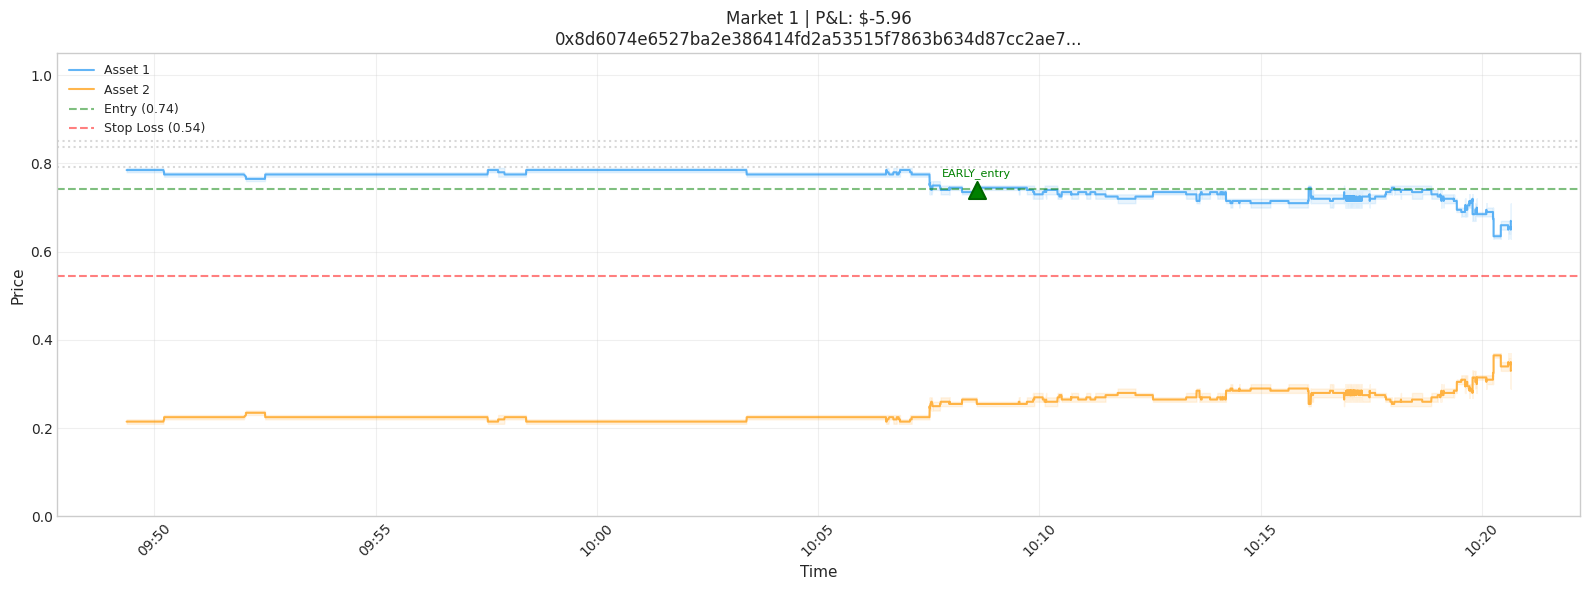

In [60]:
# Visualize results
# Uncomment after running backtest:

#plot_backtest(df, results, market_index=0)
plot_all_markets(df, results)

---
## 10. Run Optimization

Load all datasets and run Optuna to find the best parameters across all days simultaneously.
This prevents overfitting to a single day's market conditions.

In [ ]:
# Load all datasets for optimization
# Uncomment to run:

df_24 = load_data(DATA_PATHS['24jan'])
df_25 = load_data(DATA_PATHS['25jan'])
df_26 = load_data(DATA_PATHS['26jan'])
df_27 = load_data(DATA_PATHS['27jan'])
df_01feb = load_data(DATA_PATHS['01feb'])
df_02feb = load_data(DATA_PATHS['02feb'])

In [ ]:
# Define datasets for optimization — each entry is (dataframe, known_winners, selected_markets, label)
datasets = [
    (df_24, known_winners_24jan, selected_markets_24jan, '24jan'),
    (df_25, known_winners_25jan, selected_markets_25jan, '25jan'),
    (df_26, known_winners_26jan, selected_markets_26jan, '26jan'),
    (df_27, known_winners_27jan, selected_markets_27jan, '27jan'),
    (df_01feb, known_winners_1feb, selected_markets_1feb, '01feb'),
    (df_02feb, known_winners_2feb, selected_markets_2feb, '02feb'),
]

In [ ]:
# Run standard optimization
study, best_params, results = run_optuna(datasets, n_trials=200)

---
## 11. Run ML Market-Adaptive Optimization

Uses the Optuna study from Section 10 to train an ML model and predict market-adaptive parameters.

**Prerequisites:** Run sections 10 first (Optuna optimization must complete so we have trial history).

In [ ]:
# ── Step 1: Prepare the datasets (reuse from Optuna) ─────────────────────────
# The 'prepared' list is built internally by run_optuna. We rebuild it here
# from the same datasets list so the ML functions can access the DataFrames.

prepared_datasets = []
for i, item in enumerate(datasets):
    if len(item) == 4:
        data, known_winners, selected_markets, name = item
    elif len(item) == 3:
        data, known_winners, selected_markets = item
        name = f'dataset_{i+1}'

    if isinstance(data, str):
        data = pd.read_parquet(data)

    data = data.copy()
    data['datetime'] = pd.to_datetime(data['datetime'])

    if selected_markets is not None:
        if isinstance(selected_markets, dict):
            selected_markets = list(selected_markets.keys())
        data = data[data['market_id'].isin(selected_markets)]

    data = data[data['ob_best_bid'].notna() & data['ob_best_ask'].notna()].copy()

    # Resample to 1s (same as run_optuna default)
    data['bucket'] = data['datetime'].dt.floor('1s')
    data = data.groupby(['market_id', 'asset_id', 'bucket']).last().reset_index()
    data = data.drop(columns=['datetime']).rename(columns={'bucket': 'datetime'})
    data = data.sort_values('datetime')

    prepared_datasets.append((data, known_winners, name))

print(f"✅ Prepared {len(prepared_datasets)} datasets for ML pipeline")

In [ ]:
# ── Step 2: Build ML training dataset from Optuna trial history ──────────────
ml_df = build_ml_dataset(study, prepared_datasets)
ml_df.head()

In [ ]:
# ── Step 3: Train the ML model ────────────────────────────────────────────────
model, feature_names, cv_scores, importance_df = train_param_predictor(
    ml_df,
    model_type='random_forest',   # or 'gradient_boosting'
    n_estimators=200,
    cv_folds=5,
    plot=True
)

In [ ]:
# ── Step 4: Predict optimal params for each dataset ──────────────────────────
# This runs the ML predictor on every dataset and compares with Optuna's best.

ml_results = {}
for data, known_winners, name in prepared_datasets:
    print(f"\n{'#'*60}")
    print(f"  DATASET: {name}")
    print(f"{'#'*60}")
    ml_results[name] = predict_best_params(
        model=model,
        feature_names=feature_names,
        target_df=data,
        known_winners=known_winners,
        n_candidates=100_000,
        top_k=10,
        validate=True,
        initial_capital=500,
        global_tp_pct=0.07,
        optuna_best_params=best_params,
    )

In [ ]:
# ── Step 5: Summary — Optuna vs ML across all datasets ───────────────────────

print(f"\n{'='*70}")
print(f"{'🏆 FINAL COMPARISON: OPTUNA vs ML':^70}")
print(f"{'='*70}")
print(f"\n{'Dataset':<12} {'Optuna':>12} {'ML Best':>12} {'Δ':>10} {'Winner':>10}")
print(f"{'-'*56}")

optuna_total = 0
ml_total = 0

for name, mr in ml_results.items():
    opt_ret = mr['optuna_result']['total_return'] if mr['optuna_result'] else float('nan')
    ml_ret = mr['ml_best_return'] if mr['ml_best_return'] is not None else float('nan')

    optuna_total += opt_ret if not np.isnan(opt_ret) else 0
    ml_total += ml_ret if not np.isnan(ml_ret) else 0

    delta = ml_ret - opt_ret if not (np.isnan(ml_ret) or np.isnan(opt_ret)) else 0
    winner = "ML" if delta > 0.001 else ("Optuna" if delta < -0.001 else "Tie")

    print(f"{name:<12} {opt_ret*100:>+10.2f}% {ml_ret*100:>+10.2f}% {delta*100:>+8.2f}% {winner:>10}")

n_ds = len(ml_results)
print(f"{'-'*56}")
print(f"{'AVERAGE':<12} {optuna_total/n_ds*100:>+10.2f}% {ml_total/n_ds*100:>+10.2f}% "
      f"{(ml_total-optuna_total)/n_ds*100:>+8.2f}%")
print()

# Show ML-recommended params for each dataset
print(f"\n{'='*70}")
print(f"{'📋 ML-RECOMMENDED PARAMETERS PER DATASET':^70}")
print(f"{'='*70}")
for name, mr in ml_results.items():
    if mr['ml_best_params']:
        print(f"\n  {name} (predicted: {mr['ml_best_predicted']*100:+.2f}%, actual: {mr['ml_best_return']*100:+.2f}%):")
        for k, v in sorted(mr['ml_best_params'].items()):
            print(f"      {k}: {v:.4f}" if isinstance(v, float) else f"      {k}: {v}")

In [ ]:
# ── OPTIONAL: Predict params for a NEW unseen dataset ────────────────────────
# Uncomment and modify to use on a dataset the model hasn't been trained on.
# This is the real test of generalization.

# new_df = load_data('path/to/new_data.parquet')
# new_known_winners = { ... }  # or None

# new_result = predict_best_params(
#     model=model,
#     feature_names=feature_names,
#     target_df=new_df,
#     known_winners=new_known_winners,
#     n_candidates=200_000,   # more candidates for new data
#     top_k=15,
#     validate=True,
#     initial_capital=500,
#     global_tp_pct=0.07,
# )
# print(f"\nML-recommended params for new data: {new_result['ml_best_params']}")
# print(f"Predicted return: {new_result['ml_best_predicted']*100:+.2f}%")
# print(f"Actual return:    {new_result['ml_best_return']*100:+.2f}%")

---
## Quick Reference

```python
# 1. Load reconstructed parquet data
df = load_data('snapshots_25jan_reconstructed.parquet')
list_markets(df)

# 2. Run backtest with custom parameters
results = run_backtest(df, params=my_params, known_winners=known_winners_25jan,
                       selected_markets=selected_markets_25jan, initial_capital=500)

# 3. Visualize
plot_market(df, market_index=0)              # Price chart only
plot_backtest(df, results, market_index=0)   # With trade markers
plot_all_markets(df, results)                # All markets at once

# 4. Optimize across multiple days
study, best, results = run_optuna(datasets, n_trials=200)

# 5. Analyze threshold win rates
analyze_markets(df, known_winners_25jan)
```